# §6 状態空間モデル
~ State Space Model with Kalman filter

#### Packageの読み込み

In [1]:
import numpy as np
import pandas as pd
#import pandas_profiling
import pandas.tseries.offsets as offsets

import scipy as sp
from scipy import stats
from scipy import signal

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import mlab

import seaborn as sns

import lightgbm as lgb

import datetime as dt
import math
import itertools
import warnings
from tqdm import tqdm_notebook as tqdm

#### Dataの読み込み（セクション2のまとめ）

In [2]:
df1 = pd.read_csv("./csv/japan/newly_confirmed_cases_daily.csv")

# Indexを変更し日付型に変換
df2 = df1.set_index("Date")
df2.index = pd.to_datetime(df2.index)

# ①原系列の定義
df3 = df2[(df2.index >= '2020-05-01') & (df2.index <= '2023-04-30')]
df = df3[["ALL"]].copy()
df.rename(columns={"ALL": "original"}, inplace = True)

#### その他の変数の定義（セクション3のまとめ）
(セクション4のまとめなし)

In [3]:
# ②移動平均の定義
df["MA"] = df["original"].rolling(window=7,min_periods=1).mean()

# ③対数系列の定義
c = 1e-5#ゼロを含むため極小さな値を入れる
df["log"] = np.log(df["original"]+c)

# ④一次差分系列の定義
df['1day_diff'] = df["original"].diff(1)

# ⑤季節階差（週トレンド）の定義
df['7day_diff'] =df ["original"].diff(7)

# ⑥対数1次差分系列
df["log_1day_diff"] = df["log"].diff(1) 

# ⑦対数7次差分系列
df["log_7day_diff"] = df["log"].diff(7)

# 欠損値の確認
df.head()
print(df.isna().sum())

original         0
MA               0
log              0
1day_diff        1
7day_diff        7
log_1day_diff    1
log_7day_diff    7
dtype: int64


#### 特徴量エンジニアリング

In [4]:
#原系列に対するラグ特徴量
df['lag1'] = df['original'].shift(1)
df['lag7'] = df['original'].shift(7)

#原系列に対する前日からの変化率特徴量
df['change_rate'] = df['original'].diff(1) / df['original'].shift(1)

#対数系列に対するラグ特徴量
df['loglag1'] = df['log'].shift(1)
df['loglag7'] = df['log'].shift(7)

#対数系列に対する前日からの変化率特徴量
df['log_change_rate'] = df['log'].diff(1) / df['log'].shift(1)

# ラグ特徴量によりNaNが生成されるので除去
df.dropna(inplace=True) 

#### 学習データと検証データを分割

In [5]:
train_df = df["2022-01-01":"2022-03-14"]
test_df = df["2022-03-15":"2022-03-31"]

#### 外生変数の候補を検証

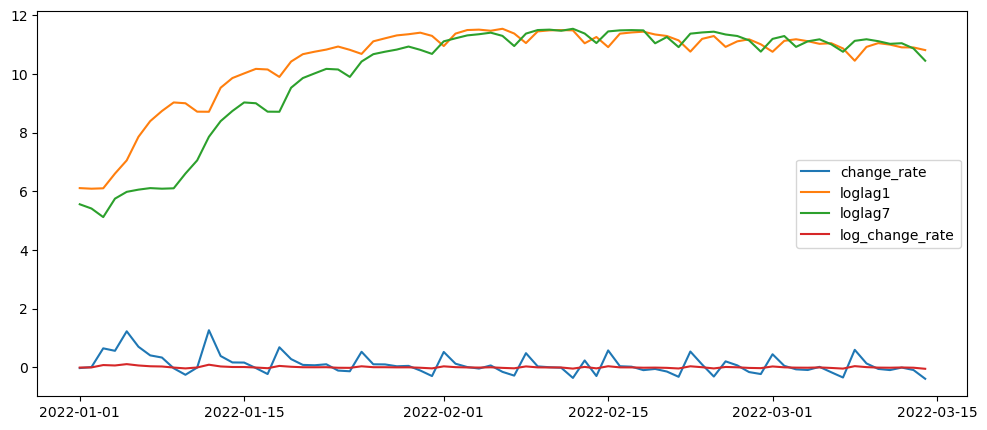

In [6]:
plt.figure(figsize=(12,5))
plt.plot(train_df.index, train_df['change_rate'],label = 'change_rate')
plt.plot(train_df.index, train_df['loglag1'],label = 'loglag1')
plt.plot(train_df.index, train_df['loglag7'],label = 'loglag7')
plt.plot(train_df.index, train_df['log_change_rate'],label = 'log_change_rate')
plt.legend()

#### 説明変数と目的変数を分割

In [7]:
y_train = train_df["original"]
y_test = test_df["original"]

X_train = train_df['log_change_rate']#外生変数として使用

#### パラメータの定義

In [8]:
# パラメータの範囲を設定
p = [0,1,2,3,4,5,6,7]
d = [0,1,2]
q = [0,1,2,3,4]
P = [0,1]
D = [0,1]
Q = [0,1]
s_values = [7]

# ARIMAと季節性パラメータの組み合わせ
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(P, D, Q)) for s in s_values]

#### モデルの定義

In [9]:
models_param = []

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(y_train, exog=X_train, trend="ct", order=param, seasonal_order=seasonal_param, freq='D')
            results = model.fit()

            ljung_box = acorr_ljungbox(results.resid, lags=[1], return_df=True)
            jarque_bera_test = jarque_bera(results.resid)

            #if ljung_box['lb_pvalue'].iloc[0] >= 0.05 and jarque_bera_test[1] >= 0.05:
            models_param.append((results.aic, param, seasonal_param, results, ljung_box['lb_pvalue'].iloc[0], jarque_bera_test[1]))
            print(f"Trying params: {param}, seasonal: {seasonal_param}")

        except Exception as e:
            print(f"Error with params: {param}, seasonal: {seasonal_param}")
            print(e)


# AIC でソート
models_param.sort(key=lambda x: x[0])

# リストをデータフレームに変換
df_models_param = pd.DataFrame(models_param, columns=['AIC', 'Params', 'Seasonal_Params', 'Model', 'Ljung-Box p-value', 'Jarque-Bera p-value'])

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 Thi

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15950D+01    |proj g|=  4.61682D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2      4      1     0     0   3.205D-07   1.159D+01
  F =   11.594594753612929     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Trying params: (0, 0, 0), seasonal: (0, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are 

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


At iterate   20    f=  1.13629D+01    |proj g|=  3.12527D-03

At iterate   25    f=  1.13601D+01    |proj g|=  4.59875D-02

At iterate   30    f=  1.13244D+01    |proj g|=  4.73722D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     46      1     0     0   2.390D-05   1.132D+01
  F =   11.324191767089678     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (0, 0, 0), seasonal: (1, 0, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.83016D+00    |proj g|=  5.84781D-04

At iterate   15    f=  9.82965D+00    |proj g|=  1.35398D-02

At iterate   20    f=  9.81381D+00    |proj g|=  5.13439D-02

At iterate   25    f=  9.80949D+00    |proj g|=  4.39062D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     32      1     0     0   4.391D-06   9.809D+00
  F =   9.8094879941855311     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Trying params: (0, 0, 0), seasonal: (1, 1, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0      

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.12875D+01    |proj g|=  8.81565D-03
  ys=-5.581E-02  -gs= 3.818E-03 BFGS update SKIPPED

At iterate   10    f=  1.12107D+01    |proj g|=  8.43279D-03

At iterate   15    f=  1.12104D+01    |proj g|=  4.32861D-05

At iterate   20    f=  1.12104D+01    |proj g|=  4.37013D-03

At iterate   25    f=  1.12076D+01    |proj g|=  1.81423D-02

At iterate   30    f=  1.12065D+01    |proj g|=  2.90100D-05

At iterate   35    f=  1.12061D+01    |proj g|=  9.51231D-03

At iterate   40    f=  1.11504D+01    |proj g|=  1.65221D-01

At iterate   45    f=  1.09068D+01    |proj g|=  1.08617D-02

At iterate   50    f=  1.09046D+01    |proj g|=  7.45823D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is


At iterate    5    f=  9.76815D+00    |proj g|=  9.03017D-03

At iterate   10    f=  9.75429D+00    |proj g|=  1.44420D-01

At iterate   15    f=  9.72678D+00    |proj g|=  3.06873D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     21      1     0     0   9.452D-06   9.727D+00
  F =   9.7267792575633685     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Trying params: (0, 0, 1), seasonal: (0, 1, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


At iterate   10    f=  1.14267D+01    |proj g|=  3.03343D-03

At iterate   15    f=  1.14207D+01    |proj g|=  3.07672D-03
  ys=-1.593E-01  -gs= 3.365E-02 BFGS update SKIPPED

At iterate   20    f=  1.12774D+01    |proj g|=  1.60199D-02

At iterate   25    f=  1.12757D+01    |proj g|=  4.14865D-03

At iterate   30    f=  1.12737D+01    |proj g|=  8.56915D-03

At iterate   35    f=  1.12688D+01    |proj g|=  2.46992D-03

At iterate   40    f=  1.12675D+01    |proj g|=  1.99775D-04

At iterate   45    f=  1.12666D+01    |proj g|=  1.98631D-03

At iterate   50    f=  1.12578D+01    |proj g|=  1.09421D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  S

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  9.74837D+00    |proj g|=  1.54218D-01

At iterate   20    f=  9.72613D+00    |proj g|=  1.47147D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     24      1     0     0   9.558D-06   9.726D+00
  F =   9.7261258246024145     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Trying params: (0, 0, 1), seasonal: (1, 1, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00401D+01    |proj g|=  1.05884D+00

At iterate    5    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.11481D+01    |proj g|=  3.02580D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8      9      1     0     0   6.156D-05   1.115D+01
  F =   11.148102503110582     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (0, 0, 2), seasonal: (0, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12218D+01    |proj g|=  8.18053D-02

At iterate    5    f=  1.12105D+01    |proj g|=  8.62448D-04

At iterate   10    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   35    f=  9.66738D+00    |proj g|=  1.90919D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     35     39      1     0     0   1.909D-05   9.667D+00
  F =   9.6673769119575415     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (0, 0, 2), seasonal: (0, 1, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.18397D+01    |proj g|=  1.60284D+01

At iterate    5    f=  1.23105D+01    |proj g|=  3.93438D-01

At iterate   10    f

 This problem is unconstrained.



At iterate   40    f=  1.11459D+01    |proj g|=  9.49301D-03

At iterate   45    f=  1.11329D+01    |proj g|=  5.95311D-02

At iterate   50    f=  1.11197D+01    |proj g|=  1.00800D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     68      1     1     0   1.008D-02   1.112D+01
  F =   11.119717995889919     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Trying params: (0, 0, 2), seasonal: (1, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   25    f=  1.11176D+01    |proj g|=  5.70048D-02

At iterate   30    f=  1.11146D+01    |proj g|=  5.61654D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     31     46      1     1     0   3.294D-05   1.111D+01
  F =   11.114561676002159     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (0, 0, 2), seasonal: (1, 0, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.89844D+00    |proj g|=  3.38606D-01

At iterate    5    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.99504D+00    |proj g|=  8.14251D-01

At iterate    5    f=  9.74124D+00    |proj g|=  3.49748D-02

At iterate   10    f=  9.73118D+00    |proj g|=  1.20963D-02

At iterate   15    f=  9.73092D+00    |proj g|=  1.85265D-03

At iterate   20    f=  9.73083D+00    |proj g|=  3.48044D-03

At iterate   25    f=  9.72350D+00    |proj g|=  2.28429D-02

At iterate   30    f=  9.67044D+00    |proj g|=  7.48553D-02

At iterate   35    f=  9.65923D+00    |proj g|=  2.99496D-02

At iterate   40    f=  9.65794D+00    |proj g|=  6.95745D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  1.10523D+01    |proj g|=  6.46793D-02

At iterate   20    f=  1.10426D+01    |proj g|=  3.03342D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     24     36      1     0     0   3.869D-05   1.104D+01
  F =   11.042522711152122     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (0, 0, 3), seasonal: (0, 0, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.73293D+00    |proj g|=  3.27025D-01

At iterate    5    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.69538D+00    |proj g|=  5.75833D-03

At iterate   10    f=  9.69535D+00    |proj g|=  1.35518D-03

At iterate   15    f=  9.69419D+00    |proj g|=  2.38209D-02

At iterate   20    f=  9.63699D+00    |proj g|=  1.48196D-01

At iterate   25    f=  9.61304D+00    |proj g|=  1.93071D-02

At iterate   30    f=  9.61031D+00    |proj g|=  3.52624D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     32     38      1     0     0   1.962D-05   9.610D+00
  F =   9.6103067914212943     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (0, 0, 3), seasonal: (0, 1, 1, 7)
RU

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.31133D+01    |proj g|=  3.51478D-01

At iterate   10    f=  1.12717D+01    |proj g|=  3.73693D-01

At iterate   15    f=  1.11323D+01    |proj g|=  1.57874D-01

At iterate   20    f=  1.11048D+01    |proj g|=  1.68927D-02

At iterate   25    f=  1.10803D+01    |proj g|=  2.00446D-02

At iterate   30    f=  1.10787D+01    |proj g|=  1.58777D-03

At iterate   35    f=  1.10787D+01    |proj g|=  1.00860D-03

At iterate   40    f=  1.10782D+01    |proj g|=  1.65611D-02

At iterate   45    f=  1.10581D+01    |proj g|=  4.89876D-02

At iterate   50    f=  1.10471D+01    |proj g|=  2.49260D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   25    f=  1.11684D+01    |proj g|=  4.62228D-01

At iterate   30    f=  1.11393D+01    |proj g|=  1.73554D-02

At iterate   35    f=  1.11393D+01    |proj g|=  9.83970D-03

At iterate   40    f=  1.11390D+01    |proj g|=  2.14815D-01

At iterate   45    f=  1.10828D+01    |proj g|=  1.22256D-01

At iterate   50    f=  1.10490D+01    |proj g|=  4.74019D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     71      1     0     0   4.740D-02   1.105D+01
  F =   11.049045488047316     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Trying params: (0, 0, 3), seasonal: (1, 0, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.89171D+00    |proj g|=  3.54575D-01

At iterate    5    f=  9.69264D+00    |proj g|=  1.53526D-02

At iterate   10    f=  9.69251D+00    |proj g|=  6.43936D-04

At iterate   15    f=  9.69239D+00    |proj g|=  1.18948D-02

At iterate   20    f=  9.67869D+00    |proj g|=  1.17611D-01

At iterate   25    f=  9.62712D+00    |proj g|=  7.73346D-02

At iterate   30    f=  9.62441D+00    |proj g|=  2.11753D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

      

 This problem is unconstrained.



At iterate    5    f=  9.70030D+00    |proj g|=  7.89089D-02

At iterate   10    f=  9.69047D+00    |proj g|=  6.33227D-03

At iterate   15    f=  9.69025D+00    |proj g|=  1.10668D-03

At iterate   20    f=  9.68986D+00    |proj g|=  2.18331D-02

At iterate   25    f=  9.66519D+00    |proj g|=  1.29894D-01

At iterate   30    f=  9.60062D+00    |proj g|=  1.54718D-02

At iterate   35    f=  9.59909D+00    |proj g|=  1.49042D-02

At iterate   40    f=  9.59898D+00    |proj g|=  2.22544D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     41     46      1     0     0   2.225D-05   9.599D+00
  F =   9.59898287098

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 Thi


At iterate   10    f=  9.28812D+00    |proj g|=  2.44121D-03

At iterate   15    f=  9.28810D+00    |proj g|=  1.77327D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     17      1     0     0   1.773D-05   9.288D+00
  F =   9.2880976480594484     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (0, 1, 0), seasonal: (0, 1, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03383D+01    |proj g|=  5.37158D-02

At iterate    5    f

 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  9.27880D+00    |proj g|=  1.20838D-03

At iterate   20    f=  9.27873D+00    |proj g|=  2.15813D-05

At iterate   25    f=  9.27868D+00    |proj g|=  3.70106D-04

At iterate   30    f=  9.27636D+00    |proj g|=  8.71882D-03

At iterate   35    f=  9.26449D+00    |proj g|=  2.74403D-03

At iterate   40    f=  9.26390D+00    |proj g|=  1.47208D-03

At iterate   45    f=  9.26387D+00    |proj g|=  6.79601D-04

At iterate   50    f=  9.26386D+00    |proj g|=  4.56057D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     58      1     0     0   4.561D-04   9.264D+00
  F =   9.26385546690

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is

At iterate   10    f=  1.04773D+01    |proj g|=  6.34617D-03

At iterate   15    f=  1.04771D+01    |proj g|=  4.05667D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     18      1     0     0   4.057D-06   1.048D+01
  F =   10.477139441353314     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Trying params: (0, 1, 1), seasonal: (0, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03792D+01    |proj g|=  9.58067D-02

At iterate    5    f=

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.28060D+00    |proj g|=  5.89502D-03

At iterate   15    f=  9.28042D+00    |proj g|=  1.19245D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     19      1     0     0   1.196D-05   9.280D+00
  F =   9.2804155861041213     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (0, 1, 1), seasonal: (0, 1, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03490D+01    |proj g|=  7.92788D-02

At iterate    5    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f=  9.26796D+00    |proj g|=  1.05842D-02

At iterate   25    f=  9.26781D+00    |proj g|=  6.34518D-05

At iterate   30    f=  9.26779D+00    |proj g|=  2.43307D-03

At iterate   35    f=  9.26592D+00    |proj g|=  2.51152D-02

At iterate   40    f=  9.25048D+00    |proj g|=  1.01797D-02

At iterate   45    f=  9.24852D+00    |proj g|=  7.76546D-04

At iterate   50    f=  9.24830D+00    |proj g|=  1.83677D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62      1     0     0   1.837D-03   9.248D+00
  F =   9.2483046721197031     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.04966D+01    |proj g|=  5.34751D-04

At iterate   10    f=  1.04964D+01    |proj g|=  1.43013D-02

At iterate   15    f=  1.04914D+01    |proj g|=  3.08345D-02

At iterate   20    f=  1.04904D+01    |proj g|=  2.29162D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     23      1     0     0   2.292D-05   1.049D+01
  F =   10.490354271942175     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (0, 1, 2), seasonal: (0, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0      

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.33649D+00    |proj g|=  5.44413D-03

At iterate   15    f=  9.33620D+00    |proj g|=  6.04181D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     22      1     0     0   9.154D-06   9.336D+00
  F =   9.3361737076064948     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Trying params: (0, 1, 2), seasonal: (0, 1, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.30394D+00    |proj g|=  1.49357D-01

At iterate    5    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   30    f=  1.03569D+01    |proj g|=  1.97953D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     33     37      1     0     0   1.466D-05   1.036D+01
  F =   10.356855732967807     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (0, 1, 2), seasonal: (1, 0, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.31004D+00    |proj g|=  1.24804D-01

At iterate    5    f=  9.29823D+00    |proj g|=  5.27086D-05

           * * *

Ti

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f=  9.27747D+00    |proj g|=  3.43992D-02

At iterate   25    f=  9.27614D+00    |proj g|=  4.54850D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     27     31      1     0     0   2.811D-05   9.276D+00
  F =   9.2761390304494782     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (0, 1, 2), seasonal: (1, 1, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12103D+01    |proj g|=  8.89086D-01

At iterate    5    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  1.03828D+01    |proj g|=  1.09558D-02

At iterate   20    f=  1.03729D+01    |proj g|=  5.75925D-02

At iterate   25    f=  1.03687D+01    |proj g|=  5.01252D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     27     30      1     0     0   2.482D-05   1.037D+01
  F =   10.368676067935397     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (0, 1, 3), seasonal: (0, 0, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.27073D+00    |proj g|=  3.38522D-03

At iterate   10    f=  9.27071D+00    |proj g|=  2.27012D-03

At iterate   15    f=  9.27017D+00    |proj g|=  1.14244D-02

At iterate   20    f=  9.27001D+00    |proj g|=  5.12028D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     21     24      1     0     0   4.644D-05   9.270D+00
  F =   9.2700127874880831     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (0, 1, 3), seasonal: (0, 1, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0      

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f=  1.04108D+01    |proj g|=  5.83161D-02

At iterate   25    f=  1.04076D+01    |proj g|=  7.12093D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     26     29      1     0     0   1.605D-05   1.041D+01
  F =   10.407627096616688     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (0, 1, 3), seasonal: (1, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.84683D+01    |proj g|=  1.48988D+01

At iterate    5    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.29745D+00    |proj g|=  6.82726D-02

At iterate    5    f=  9.27706D+00    |proj g|=  8.01660D-02

At iterate   10    f=  9.26378D+00    |proj g|=  1.16140D-02

At iterate   15    f=  9.26332D+00    |proj g|=  2.44635D-03

At iterate   20    f=  9.26005D+00    |proj g|=  2.69271D-02

At iterate   25    f=  9.25768D+00    |proj g|=  7.17907D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     28     32      1     0     0   

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 Thi


At iterate    5    f=  9.55177D+00    |proj g|=  7.81762D-04

At iterate   10    f=  9.55172D+00    |proj g|=  7.92610D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     18      1     0     0   8.718D-06   9.552D+00
  F =   9.5517240736084830     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Trying params: (0, 2, 0), seasonal: (1, 1, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.54377D+00    |proj g|=  5.56646D-02

At iterate    5    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   40    f=  1.03701D+01    |proj g|=  4.71631D-03

At iterate   45    f=  1.03613D+01    |proj g|=  1.15421D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     60      1     0     0   2.595D-06   1.036D+01
  F =   10.361339047512924     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Trying params: (0, 2, 1), seasonal: (0, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04098D+01    |proj g|=  1.57620D-01

At iterate    5    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.21060D+00    |proj g|=  2.45159D-03

At iterate   15    f=  9.21000D+00    |proj g|=  1.19557D-04

At iterate   20    f=  9.20973D+00    |proj g|=  5.07237D-04

At iterate   25    f=  9.19909D+00    |proj g|=  5.60801D-02

At iterate   30    f=  9.18718D+00    |proj g|=  3.06359D-05

At iterate   35    f=  9.18717D+00    |proj g|=  9.80140D-04

At iterate   40    f=  9.18687D+00    |proj g|=  1.18985D-02

At iterate   45    f=  9.18049D+00    |proj g|=  5.04671D-02

At iterate   50    f=  9.17346D+00    |proj g|=  2.58562D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     73   

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   20    f=  1.03332D+01    |proj g|=  3.64876D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     20     23      1     0     0   3.649D-05   1.033D+01
  F =   10.333167927124091     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (0, 2, 1), seasonal: (1, 0, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.24810D+00    |proj g|=  1.89685D-02

At iterate    5    f=  9.24480D+00    |proj g|=  1.79883D-02

At iterate   10    f

 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.23908D+00    |proj g|=  4.58723D-02

At iterate   10    f=  9.22193D+00    |proj g|=  2.59439D-02

At iterate   15    f=  9.20900D+00    |proj g|=  2.96001D-03

At iterate   20    f=  9.20808D+00    |proj g|=  3.82177D-04

At iterate   25    f=  9.20807D+00    |proj g|=  2.35089D-04

At iterate   30    f=  9.20786D+00    |proj g|=  3.27111D-03

At iterate   35    f=  9.18340D+00    |proj g|=  1.21213D-02

At iterate   40    f=  9.18131D+00    |proj g|=  4.27990D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     50      1     0     0   3.223D-05   9.181D+00
  F =   9.18130716216

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This prob


At iterate   15    f=  1.02513D+01    |proj g|=  4.74449D-02

At iterate   20    f=  1.02470D+01    |proj g|=  7.98790D-03

At iterate   25    f=  1.02462D+01    |proj g|=  4.04379D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     32      1     0     0   2.766D-05   1.025D+01
  F =   10.246181302207036     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (0, 2, 2), seasonal: (0, 0, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   35    f=  9.21631D+00    |proj g|=  2.69020D-03

At iterate   40    f=  9.21522D+00    |proj g|=  6.33146D-04

At iterate   45    f=  9.21520D+00    |proj g|=  4.71797D-05

At iterate   50    f=  9.21517D+00    |proj g|=  5.59682D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     65      1     0     0   5.597D-04   9.215D+00
  F =   9.2151705812518365     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Trying params: (0, 2, 2), seasonal: (0, 1, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0      

 This problem is unconstrained.



At iterate   20    f=  9.19431D+00    |proj g|=  9.95514D-03

At iterate   25    f=  9.18907D+00    |proj g|=  2.32402D-03

At iterate   30    f=  9.18853D+00    |proj g|=  8.58325D-04

At iterate   35    f=  9.17396D+00    |proj g|=  3.15574D-02

At iterate   40    f=  9.17009D+00    |proj g|=  3.16509D-05

At iterate   45    f=  9.17006D+00    |proj g|=  8.37286D-04
  ys=-1.203E-04  -gs= 4.722E-04 BFGS update SKIPPED

At iterate   50    f=  9.16830D+00    |proj g|=  9.03546D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     89      1     1     0   9.035D-03   9.168D+00
  F =   9.1682959190394691     

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anacon


At iterate   25    f=  1.02050D+01    |proj g|=  9.31662D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     35      1     0     0   3.561D-05   1.020D+01
  F =   10.204983001000498     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (0, 2, 2), seasonal: (1, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05481D+01    |proj g|=  5.72808D-01

At iterate    5    f=  1.02664D+01    |proj g|=  1.82879D-02

At iterate   10    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f=  9.19365D+00    |proj g|=  1.08754D-03

At iterate   25    f=  9.19307D+00    |proj g|=  1.31759D-02

At iterate   30    f=  9.19237D+00    |proj g|=  1.14344D-03

At iterate   35    f=  9.19236D+00    |proj g|=  1.12293D-03

At iterate   40    f=  9.19153D+00    |proj g|=  1.59792D-02

At iterate   45    f=  9.18500D+00    |proj g|=  3.33648D-03

At iterate   50    f=  9.18495D+00    |proj g|=  6.87749D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     70      1     0     0   6.877D-04   9.185D+00
  F =   9.1849512342966886     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.32096D+00    |proj g|=  5.75116D-02

At iterate   10    f=  9.22157D+00    |proj g|=  5.05294D-02

At iterate   15    f=  9.21703D+00    |proj g|=  6.43365D-04

At iterate   20    f=  9.21650D+00    |proj g|=  3.74336D-04

At iterate   25    f=  9.21648D+00    |proj g|=  4.10186D-05

At iterate   30    f=  9.21631D+00    |proj g|=  3.95026D-04
  ys=-6.404E-05  -gs= 1.954E-04 BFGS update SKIPPED

At iterate   35    f=  9.21590D+00    |proj g|=  9.22029D-05

At iterate   40    f=  9.21590D+00    |proj g|=  7.03706D-05

At iterate   45    f=  9.21532D+00    |proj g|=  9.12167D-03

At iterate   50    f=  9.20282D+00    |proj g|=  1.58123D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


At iterate   15    f=  1.03866D+01    |proj g|=  1.87560D-02

At iterate   20    f=  1.03758D+01    |proj g|=  2.47074D-03

At iterate   25    f=  1.03609D+01    |proj g|=  7.66709D-02

At iterate   30    f=  1.03480D+01    |proj g|=  1.34868D-02

At iterate   35    f=  1.03455D+01    |proj g|=  2.44145D-03

At iterate   40    f=  1.03454D+01    |proj g|=  1.10472D-04

At iterate   45    f=  1.03453D+01    |proj g|=  1.21234D-03

At iterate   50    f=  1.03436D+01    |proj g|=  2.03884D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     64      1     0     0   2.039D-02   1.034D+01
  F =   10.3435705719

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   15    f=  1.02827D+01    |proj g|=  1.08848D-01

At iterate   20    f=  1.02680D+01    |proj g|=  1.88190D-03

At iterate   25    f=  1.02680D+01    |proj g|=  9.48530D-05

At iterate   30    f=  1.02679D+01    |proj g|=  3.52823D-03

At iterate   35    f=  1.02519D+01    |proj g|=  2.93817D-02

At iterate   40    f=  1.02126D+01    |proj g|=  8.32792D-03

At iterate   45    f=  1.02118D+01    |proj g|=  2.45234D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     48     54      1     0     0   2.786D-05   1.021D+01
  F =   10.211750689660910     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.28216D+00    |proj g|=  2.81369D-02

At iterate   10    f=  9.24310D+00    |proj g|=  1.51220D-01

At iterate   15    f=  9.22040D+00    |proj g|=  3.92908D-03

At iterate   20    f=  9.21562D+00    |proj g|=  6.31926D-03

At iterate   25    f=  9.21516D+00    |proj g|=  3.69199D-04

At iterate   30    f=  9.21515D+00    |proj g|=  4.20071D-04

At iterate   35    f=  9.21461D+00    |proj g|=  6.10677D-03

At iterate   40    f=  9.21383D+00    |proj g|=  2.77429D-04

At iterate   45    f=  9.21306D+00    |proj g|=  5.20012D-03

At iterate   50    f=  9.21285D+00    |proj g|=  2.75570D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


Trying params: (0, 2, 3), seasonal: (0, 1, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.37491D+00    |proj g|=  2.87157D-01

At iterate    5    f=  9.23448D+00    |proj g|=  2.30706D-02

At iterate   10    f=  9.23119D+00    |proj g|=  2.51427D-02

At iterate   15    f=  9.18366D+00    |proj g|=  5.55310D-02

At iterate   20    f=  9.16346D+00    |proj g|=  5.21415D-03

At iterate   25    f=  9.16327D+00    |proj g|=  1.05780D-04

At iterate   30    f=  9.16327D+00    |proj g|=  1.96177D-04

At iterate   35    f=  9.16317D+00    |proj g|=  2.82931D-03

At iterate   40    f=  9.15531D+00    |proj g|=  2.69924D-02

At iterate   45    f=  9.15252D+00    |proj g|=  3.77041D-04

At iterate   50    f=  9.15202D+00    |proj g|=  7.54964D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tni

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   35    f=  1.02577D+01    |proj g|=  4.60339D-02

At iterate   40    f=  1.02002D+01    |proj g|=  2.51007D-02

At iterate   45    f=  1.01868D+01    |proj g|=  1.98301D-03

At iterate   50    f=  1.01860D+01    |proj g|=  1.67493D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     55      1     0     0   1.675D-03   1.019D+01
  F =   10.185958776354006     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Trying params: (0, 2, 3), seasonal: (1, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0      

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   20    f=  1.02592D+01    |proj g|=  6.13709D-03

At iterate   25    f=  1.02584D+01    |proj g|=  7.18900D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     26     30      1     0     0   7.189D-05   1.026D+01
  F =   10.258412506618082     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (0, 2, 3), seasonal: (1, 0, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.28914D+00    |proj g|=  1.50653D-01

At iterate    5    f

 This problem is unconstrained.



At iterate   25    f=  9.18780D+00    |proj g|=  5.41596D-04

At iterate   30    f=  9.18780D+00    |proj g|=  1.82378D-04

At iterate   35    f=  9.18776D+00    |proj g|=  3.50405D-03

At iterate   40    f=  9.18450D+00    |proj g|=  3.33014D-02

At iterate   45    f=  9.17904D+00    |proj g|=  6.43841D-04

At iterate   50    f=  9.17887D+00    |proj g|=  5.93501D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     61      1     0     0   5.935D-03   9.179D+00
  F =   9.1788733505879527     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Trying params: (0, 2, 3), seasonal: (1, 1, 0, 7)
RU

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.22753D+00    |proj g|=  6.48147D-03

At iterate   15    f=  9.19268D+00    |proj g|=  5.06484D-02

At iterate   20    f=  9.16216D+00    |proj g|=  1.19974D-02

At iterate   25    f=  9.15844D+00    |proj g|=  5.07473D-03

At iterate   30    f=  9.15739D+00    |proj g|=  1.12623D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     33     37      1     0     0   3.982D-05   9.157D+00
  F =   9.1573795446147965     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (0, 2, 3), seasonal: (1, 1, 1, 7)


/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06771D+01    |proj g|=  3.64175D-02

At iterate    5    f=  1.06694D+01    |proj g|=  5.39014D-04

At iterate   10    f=  1.06688D+01    |proj g|=  1.39561D-02

At iterate   15    f=  1.06593D+01    |proj g|=  7.86153D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     18      1     0     0   1.623D-05   1.066D+01
  F =   10.659327445283136     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying p

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.58683D+00    |proj g|=  1.09776D-03

At iterate   10    f=  9.58193D+00    |proj g|=  3.28221D-02

At iterate   15    f=  9.57188D+00    |proj g|=  9.47721D-04

At iterate   20    f=  9.57188D+00    |proj g|=  5.99552D-04

At iterate   25    f=  9.57175D+00    |proj g|=  8.83234D-03

At iterate   30    f=  9.56637D+00    |proj g|=  9.87852D-03

At iterate   35    f=  9.56435D+00    |proj g|=  7.69965D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     42      1     0     0   6.914D-06   9.564D+00
  F =   9.5643504884318116     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.06285D+01    |proj g|=  2.06108D-01

At iterate   10    f=  1.04961D+01    |proj g|=  2.12233D-03

At iterate   15    f=  1.04961D+01    |proj g|=  1.39858D-03

At iterate   20    f=  1.04956D+01    |proj g|=  1.64489D-02

At iterate   25    f=  1.04940D+01    |proj g|=  2.46777D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     38      1     0     0   3.456D-05   1.049D+01
  F =   10.494018233488207     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (1, 0, 0), seasonal: (1, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision =

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     25      1     0     0   9.178D-06   9.582D+00
  F =   9.5820926966238336     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Trying params: (1, 0, 0), seasonal: (1, 1, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.65385D+00    |proj g|=  4.59389D-01

At iterate    5    f=  9.58702D+00    |proj g|=  9.70691D-03

At iterate   10    f=  9.58679D+00    |proj g|=  1.73702D-02

At iterate   15    f=  9.58651D+00    

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  1.06670D+01    |proj g|=  6.58657D-03

At iterate   15    f=  1.06575D+01    |proj g|=  4.71613D-02

At iterate   20    f=  1.06540D+01    |proj g|=  1.18240D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     24      1     0     0   2.122D-05   1.065D+01
  F =   10.653965490639084     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (1, 0, 1), seasonal: (0, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f=  9.53968D+00    |proj g|=  8.85802D-03

At iterate   25    f=  9.53920D+00    |proj g|=  9.62963D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     25     31      1     0     0   9.630D-06   9.539D+00
  F =   9.5391959334338594     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Trying params: (1, 0, 1), seasonal: (0, 1, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.50465D+01    |proj g|=  7.80062D+00

At iterate    5    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.19234D+01    |proj g|=  4.99603D-01

At iterate   10    f=  1.05687D+01    |proj g|=  2.58441D-01

At iterate   15    f=  1.05034D+01    |proj g|=  2.04573D-02

At iterate   20    f=  1.05021D+01    |proj g|=  2.00777D-03

At iterate   25    f=  1.05021D+01    |proj g|=  2.19672D-03

At iterate   30    f=  1.05012D+01    |proj g|=  2.58215D-02

At iterate   35    f=  1.04963D+01    |proj g|=  2.64496D-03

At iterate   40    f=  1.04963D+01    |proj g|=  2.80098D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     40     55      1     0     0   2.801D-05   1.050D+01
  F =   10.4962864254

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.99096D+00    |proj g|=  1.32687D+00

At iterate    5    f=  9.57007D+00    |proj g|=  1.00837D-02

At iterate   10    f=  9.56502D+00    |proj g|=  2.08153D-02

At iterate   15    f=  9.56350D+00    |proj g|=  1.17781D-03

At iterate   20    f=  9.56262D+00    |proj g|=  1.66328D-02

At iterate   25    f=  9.55154D+00    |proj g|=  1.21416D-02

At iterate   30    f=  9.53799D+00    |proj g|=  1.96040D-02

At iterate   35    f=  9.53762D+00    |proj g|=  9.81426D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  1.06533D+01    |proj g|=  9.21562D-03

At iterate   20    f=  1.06017D+01    |proj g|=  2.55681D-01
  ys=-1.385E-01  -gs= 5.694E-03 BFGS update SKIPPED

At iterate   25    f=  1.05482D+01    |proj g|=  4.87428D-02

At iterate   30    f=  1.05453D+01    |proj g|=  2.57020D-03

At iterate   35    f=  1.05383D+01    |proj g|=  5.36781D-02

At iterate   40    f=  1.05210D+01    |proj g|=  1.00368D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     43     51      1     1     0   1.082D-05   1.052D+01
  F =   10.520977089726488     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  9.58642D+00    |proj g|=  1.02794D-01

At iterate   20    f=  9.56051D+00    |proj g|=  3.86065D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     23     26      1     0     0   5.943D-06   9.560D+00
  F =   9.5604827773920391     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Trying params: (1, 0, 2), seasonal: (0, 1, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.61970D+00    |proj g|=  2.95082D-01

At iterate    5    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   35    f=  1.05354D+01    |proj g|=  6.64716D-02

At iterate   40    f=  1.05305D+01    |proj g|=  1.71660D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     42     53      1     0     0   1.561D-05   1.053D+01
  F =   10.530508666429290     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (1, 0, 2), seasonal: (1, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.66399D+01    |proj g|=  4.08436D+01

At iterate    5    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   30    f=  1.05418D+01    |proj g|=  9.11336D-03

At iterate   35    f=  1.05288D+01    |proj g|=  1.12904D-01

At iterate   40    f=  1.05063D+01    |proj g|=  8.06364D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     44     51      1     0     0   1.449D-05   1.051D+01
  F =   10.506282084507088     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (1, 0, 2), seasonal: (1, 0, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f=  9.53655D+00    |proj g|=  4.59764D-02

At iterate   25    f=  9.53430D+00    |proj g|=  1.64370D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     26     29      1     0     0   1.135D-05   9.534D+00
  F =   9.5342963688964169     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (1, 0, 2), seasonal: (1, 1, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77622D+00    |proj g|=  7.14793D-01

At iterate    5    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  1.07535D+01    |proj g|=  1.58316D-02

At iterate   20    f=  1.07534D+01    |proj g|=  5.14163D-04

At iterate   25    f=  1.07534D+01    |proj g|=  5.89593D-03

At iterate   30    f=  1.07520D+01    |proj g|=  2.22149D-02

At iterate   35    f=  1.06972D+01    |proj g|=  2.14329D-01

At iterate   40    f=  1.06701D+01    |proj g|=  2.08430D-02

At iterate   45    f=  1.06695D+01    |proj g|=  3.13568D-02

At iterate   50    f=  1.06692D+01    |proj g|=  1.03589D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     59      1     0     0   1.036D-04   1.067D+01
  F =   10.6692226562

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  1.05255D+01    |proj g|=  5.52571D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     61      1     0     0   5.526D-05   1.053D+01
  F =   10.525505498656010     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Trying params: (1, 0, 3), seasonal: (0, 0, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.64546D+00    |proj g|=  2.07713D-01

At iterate    5    f=  9.61947D+00    |proj g|=  2.78297D-03

At iterate   10    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  1.20288D+01    |proj g|=  2.34607D+00

At iterate   15    f=  1.11900D+01    |proj g|=  1.10411D+00

At iterate   20    f=  1.10149D+01    |proj g|=  4.63623D+00

At iterate   25    f=  1.08605D+01    |proj g|=  9.13875D-01

At iterate   30    f=  1.07251D+01    |proj g|=  1.45153D-01

At iterate   35    f=  1.06626D+01    |proj g|=  1.55661D-01

At iterate   40    f=  1.05705D+01    |proj g|=  3.70590D-02

At iterate   45    f=  1.05695D+01    |proj g|=  5.11229D-04

At iterate   50    f=  1.05694D+01    |proj g|=  8.44547D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     64   

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f=  1.08577D+01    |proj g|=  9.98214D-02

At iterate   25    f=  1.08446D+01    |proj g|=  7.15145D-03

At iterate   30    f=  1.08439D+01    |proj g|=  9.41470D-02

At iterate   35    f=  1.07874D+01    |proj g|=  7.03596D-01

At iterate   40    f=  1.05714D+01    |proj g|=  1.04084D-01

At iterate   45    f=  1.05564D+01    |proj g|=  2.71895D-02

At iterate   50    f=  1.05555D+01    |proj g|=  4.82151D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     87      1     0     0   4.822D-04   1.056D+01
  F =   10.555453850854407     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   25    f=  9.54580D+00    |proj g|=  3.16154D-02

At iterate   30    f=  9.54155D+00    |proj g|=  1.73952D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     32     36      1     0     0   1.706D-05   9.542D+00
  F =   9.5415487067766893     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (1, 0, 3), seasonal: (1, 1, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.76473D+00    |proj g|=  6.17534D-01

At iterate    5    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  9.57751D+00    |proj g|=  4.24292D-02

At iterate   20    f=  9.57351D+00    |proj g|=  1.24916D-02

At iterate   25    f=  9.57230D+00    |proj g|=  1.50622D-03

At iterate   30    f=  9.57219D+00    |proj g|=  7.49011D-03

At iterate   35    f=  9.56208D+00    |proj g|=  1.16802D-01

At iterate   40    f=  9.54381D+00    |proj g|=  1.61693D-02

At iterate   45    f=  9.54310D+00    |proj g|=  1.45956D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     46     59      1     0     0   2.889D-05   9.543D+00
  F =   9.5430958924832865     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 Thi

Trying params: (1, 1, 0), seasonal: (0, 1, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.28854D+00    |proj g|=  5.83257D-02

At iterate    5    f=  9.27942D+00    |proj g|=  2.05180D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      5      7      1     0     0   2.052D-05   9.279D+00
  F =   9.2794249537742157     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (1, 1, 0), seasonal: (0, 1, 1, 7)
RUNNING THE L-BFGS-B CODE

       

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  9.26527D+00    |proj g|=  1.30700D-03

At iterate   20    f=  9.26515D+00    |proj g|=  7.78920D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     28      1     0     0   2.057D-05   9.265D+00
  F =   9.2651469443833925     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (1, 1, 0), seasonal: (1, 1, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04827D+01    |proj g|=  2.43425D-02

At iterate    5    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.33737D+00    |proj g|=  3.91444D-02

At iterate    5    f=  9.33537D+00    |proj g|=  2.92543D-04

At iterate   10    f=  9.33528D+00    |proj g|=  8.69248D-03

At iterate   15    f=  9.33458D+00    |proj g|=  5.70723D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     24      1     0     0   8.176D-06   9.335D+00
  F =   9.3345472449568216     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Trying params: (1, 1, 1), seasonal:

 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f=  9.27903D+00    |proj g|=  1.54021D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     20     23      1     0     0   1.540D-05   9.279D+00
  F =   9.2790347649575846     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (1, 1, 1), seasonal: (0, 1, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03595D+01    |proj g|=  1.14869D-01

At iterate    5    f=  1.03228D+01    |proj g|=  1.01036D-02

At iterate   10    f


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.03279D+01    |proj g|=  1.85504D-02

At iterate   10    f=  1.03199D+01    |proj g|=  7.68437D-03

At iterate   15    f=  1.03181D+01    |proj g|=  1.79187D-03

At iterate   20    f=  1.03178D+01    |proj g|=  4.27161D-04

At iterate   25    f=  1.03177D+01    |proj g|=  4.01502D-04

At iterate   30    f=  1.03174D+01    |proj g|=  5.13780D-03
  ys=-8.987E-04  -gs= 1.292E-04 BFGS update SKIPPED



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     31     60      1     1     0   5.135D-03   1.032D+01
  F =   10.317446118390547     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (1, 1, 1), seasonal: (1, 0, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.30318D+00    |proj g|=  8.08239D-02

At iterate    5    f=  9.29819D+00    |proj g|=  6.97199D-03

At iterate   10    f=  9.29814D+00    |proj g|=  8.04791D-04

At iterate   15    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihoo


At iterate   15    f=  1.05368D+01    |proj g|=  3.61503D-04

At iterate   20    f=  1.05368D+01    |proj g|=  2.50942D-03

At iterate   25    f=  1.05362D+01    |proj g|=  2.55558D-02

At iterate   30    f=  1.05344D+01    |proj g|=  3.57005D-03

At iterate   35    f=  1.05342D+01    |proj g|=  8.18938D-05

At iterate   40    f=  1.05338D+01    |proj g|=  3.93829D-03

At iterate   45    f=  1.04886D+01    |proj g|=  4.37600D-02

At iterate   50    f=  1.04818D+01    |proj g|=  9.11115D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   9.111D-05   1.048D+01
  F =   10.4817681298


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregress


At iterate    5    f=  9.27675D+00    |proj g|=  4.62986D-03

At iterate   10    f=  9.27629D+00    |proj g|=  1.96096D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     12     14      1     0     0   1.323D-05   9.276D+00
  F =   9.2762874347112305     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (1, 1, 2), seasonal: (0, 1, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08076D+01    |proj g|=  1.03972D+00

At iterate    5    f

 This problem is unconstrained.



At iterate   25    f=  1.03629D+01    |proj g|=  1.90532D-03

At iterate   30    f=  1.03615D+01    |proj g|=  1.42045D-03
  ys=-2.130E-04  -gs= 7.619E-05 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     32     60      1     1     0   5.230D-03   1.036D+01
  F =   10.361495907348669     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (1, 1, 2), seasonal: (1, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10808


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  1.03614D+01    |proj g|=  2.42882D-02

At iterate   15    f=  1.03456D+01    |proj g|=  5.84335D-03

At iterate   20    f=  1.03425D+01    |proj g|=  4.07198D-03

At iterate   25    f=  1.03419D+01    |proj g|=  4.82608D-03

At iterate   30    f=  1.03408D+01    |proj g|=  9.47368D-03
  ys=-7.144E-03  -gs= 1.646E-03 BFGS update SKIPPED



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     33     59      1     1     0   8.165D-03   1.034D+01
  F =   10.339806256314823     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (1, 1, 2), seasonal: (1, 0, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.30255D+00    |proj g|=  9.91322D-02

At iterate    5    f=  9.29390D+00    |proj g|=  4.63451D-03

At iterate   10    f=  9.29382D+00    |proj g|=  4.69813D-05

           * * *

Ti

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarn

At iterate   10    f=  1.04718D+01    |proj g|=  1.39372D-02

At iterate   15    f=  1.04643D+01    |proj g|=  5.30065D-03

At iterate   20    f=  1.04627D+01    |proj g|=  3.08095D-03

At iterate   25    f=  1.04481D+01    |proj g|=  1.38714D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     27     43      1     0     0   8.717D-04   1.045D+01
  F =   10.448072294708048     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (1, 1, 3), seasonal: (0, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0       

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates,

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.30426D+00    |proj g|=  1.59020D-01

At iterate    5    f=  9.27232D+00    |proj g|=  7.68333D-03

At iterate   10    f=  9.27052D+00    |proj g|=  3.16449D-03

At iterate   15    f=  9.27013D+00    |proj g|=  3.86752D-02

At iterate   20    f=  9.26719D+00    |proj g|=  5.67602D-03

At iterate   25    f=  9.26696D+00    |proj g|=  1.79648D-04

At iterate   30    f=  9.26688D+00    |proj g|=  4.00397D-03

At iterate   35    f=  9.26660D+00    |proj g|=  1.10934D-03

At iterate   40    f=  9.26656D+00    |proj g|=  1.29373D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  1.04061D+01    |proj g|=  1.06377D-01

At iterate   10    f=  1.03527D+01    |proj g|=  2.52286D-02

At iterate   15    f=  1.03449D+01    |proj g|=  5.54767D-03

At iterate   20    f=  1.03423D+01    |proj g|=  1.65116D-03

At iterate   25    f=  1.03417D+01    |proj g|=  1.25116D-02

At iterate   30    f=  1.03368D+01    |proj g|=  3.27297D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     34     49      1     0     0   1.403D-03   1.034D+01
  F =   10.335916545977906     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (1, 1, 3), seasonal: (1, 0, 0, 7)



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08733D+01    |proj g|=  1.20647D+00

At iterate    5    f=  1.03684D+01    |proj g|=  8.87923D-02

At iterate   10    f=  1.03242D+01    |proj g|=  3.15563D-02

At iterate   15    f=  1.03126D+01    |proj g|=  4.93355D-03

At iterate   20    f=  1.03122D+01    |proj g|=  5.11250D-04

At iterate   25    f=  1.03121D+01    |proj g|=  4.95378D-03

At iterate   30    f=  1.03075D+01    |proj g|=  9.81133D-03

At iterate   35    f=  1.03041D+01    |proj g|=  3.31362D-02

At iterate   40    f=  1.03016D+01    |proj g|=  5.50089D-03

At iterate   45    f=  1.03013D+01    |proj g|=  2.46095D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates,


At iterate    5    f=  9.28514D+00    |proj g|=  7.51430D-02

At iterate   10    f=  9.26033D+00    |proj g|=  1.67483D-02

At iterate   15    f=  9.25073D+00    |proj g|=  3.38597D-02

At iterate   20    f=  9.24556D+00    |proj g|=  4.35210D-03

At iterate   25    f=  9.24472D+00    |proj g|=  4.34949D-03

At iterate   30    f=  9.24386D+00    |proj g|=  4.70870D-04

At iterate   35    f=  9.24376D+00    |proj g|=  5.20307D-03

At iterate   40    f=  9.24289D+00    |proj g|=  1.57133D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     44     50      1     0     0   2.278D-05   9.243D+00
  F =   9.24287600167

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 Thi

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.48155D+00    |proj g|=  6.33191D-03

At iterate    5    f=  9.48151D+00    |proj g|=  2.59674D-04

At iterate   10    f=  9.48148D+00    |proj g|=  4.38393D-03

At iterate   15    f=  9.48119D+00    |proj g|=  3.91349D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     18      1     0     0   3.913D-06   9.481D+00
  F =   9.4811858559204776     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Trying p

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate    5    f=  1.04495D+01    |proj g|=  5.48287D-04

At iterate   10    f=  1.04495D+01    |proj g|=  2.80831D-04

At iterate   15    f=  1.04495D+01    |proj g|=  3.67509D-03

At iterate   20    f=  1.04493D+01    |proj g|=  1.12405D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     27      1     0     0   2.258D-05   1.045D+01
  F =   10.449282196711374     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (1, 2, 0), seasonal: (1, 0, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0      

 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  9.39837D+00    |proj g|=  1.08077D-03

At iterate   20    f=  9.39833D+00    |proj g|=  7.18582D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     23     27      1     0     0   1.373D-05   9.398D+00
  F =   9.3983245232472825     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (1, 2, 0), seasonal: (1, 1, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05266D+01    |proj g|=  2.34776D-01

At iterate    5    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.23957D+00    |proj g|=  4.50531D-03

At iterate   15    f=  9.23950D+00    |proj g|=  4.84372D-03

At iterate   20    f=  9.23919D+00    |proj g|=  6.49473D-04

At iterate   25    f=  9.23919D+00    |proj g|=  1.06669D-03

At iterate   30    f=  9.23440D+00    |proj g|=  1.58718D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     39      1     0     0   2.019D-05   9.229D+00
  F =   9.2292585037489481     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (1, 2, 1), seasonal: (0, 1, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision =

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   25    f=  9.19406D+00    |proj g|=  9.65496D-03

At iterate   30    f=  9.18136D+00    |proj g|=  5.50887D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     37      1     0     0   3.961D-05   9.181D+00
  F =   9.1813646676282428     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (1, 2, 1), seasonal: (0, 1, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04764D+01    |proj g|=  2.29499D-01

At iterate    5    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   25    f=  1.03285D+01    |proj g|=  8.56769D-04

At iterate   30    f=  1.03269D+01    |proj g|=  1.58421D-02

At iterate   35    f=  1.02718D+01    |proj g|=  5.88888D-02

At iterate   40    f=  1.02243D+01    |proj g|=  3.30992D-02

At iterate   45    f=  1.02110D+01    |proj g|=  4.71933D-03

At iterate   50    f=  1.02104D+01    |proj g|=  4.29161D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     63      1     0     0   4.292D-03   1.021D+01
  F =   10.210420993794232     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Trying params: (1, 2, 1), seasonal: (1, 0, 1, 7)
RU

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.23161D+00    |proj g|=  2.53181D-02

At iterate   10    f=  9.20957D+00    |proj g|=  7.90666D-03

At iterate   15    f=  9.20424D+00    |proj g|=  5.64918D-03

At iterate   20    f=  9.20360D+00    |proj g|=  3.45317D-05

At iterate   25    f=  9.20359D+00    |proj g|=  9.34362D-04

At iterate   30    f=  9.19705D+00    |proj g|=  5.17434D-03

At iterate   35    f=  9.19666D+00    |proj g|=  4.30131D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     45      1     0     0   2.427D-05   9.197D+00
  F =   9.1966603508335858     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.22462D+00    |proj g|=  2.37469D-02

At iterate   10    f=  9.21885D+00    |proj g|=  2.25857D-02

At iterate   15    f=  9.20068D+00    |proj g|=  1.31904D-02

At iterate   20    f=  9.19457D+00    |proj g|=  1.81233D-03

At iterate   25    f=  9.19413D+00    |proj g|=  1.05245D-04

At iterate   30    f=  9.19413D+00    |proj g|=  6.17814D-04

At iterate   35    f=  9.19370D+00    |proj g|=  4.85925D-03

At iterate   40    f=  9.18656D+00    |proj g|=  1.88618D-02

At iterate   45    f=  9.17594D+00    |proj g|=  1.01831D-02

At iterate   50    f=  9.17442D+00    |proj g|=  3.30568D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


Trying params: (1, 2, 2), seasonal: (0, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03523D+01    |proj g|=  3.30395D-01

At iterate    5    f=  1.02847D+01    |proj g|=  2.82331D-02

At iterate   10    f=  1.02479D+01    |proj g|=  1.65866D-02

At iterate   15    f=  1.02460D+01    |proj g|=  7.46386D-03

At iterate   20    f=  1.02458D+01    |proj g|=  1.49077D-03

At iterate   25    f=  1.02455D+01    |proj g|=  2.23159D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg  

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   15    f=  9.24076D+00    |proj g|=  1.89476D-03

At iterate   20    f=  9.24038D+00    |proj g|=  1.70697D-04

At iterate   25    f=  9.24030D+00    |proj g|=  4.08350D-04

At iterate   30    f=  9.23997D+00    |proj g|=  2.48671D-03

At iterate   35    f=  9.23863D+00    |proj g|=  4.88092D-04

At iterate   40    f=  9.23840D+00    |proj g|=  1.52749D-05

At iterate   45    f=  9.23838D+00    |proj g|=  8.01307D-05

At iterate   50    f=  9.23391D+00    |proj g|=  5.51262D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     79      1     0     0   5.513D-03   9.234D+00
  F =   9.23391403128

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


Trying params: (1, 2, 2), seasonal: (0, 1, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.41782D+00    |proj g|=  3.87557D-01

At iterate    5    f=  9.23273D+00    |proj g|=  1.03965D-02

At iterate   10    f=  9.18335D+00    |proj g|=  5.99440D-03

At iterate   15    f=  9.18246D+00    |proj g|=  8.51478D-03

At iterate   20    f=  9.18164D+00    |proj g|=  6.35653D-03

At iterate   25    f=  9.18087D+00    |proj g|=  1.98209D-03

At iterate   30    f=  9.18085D+00    |proj g|=  2.60304D-04

At iterate   35    f=  9.18082D+00    |proj g|=  1.37134D-03

At iterate   40    f=  9.18081D+00    |proj g|=  4.99120D-04

At iterate   45    f=  9.18007D+00    |proj g|=  7.19050D-03

At iterate   50    f=  9.16565D+00    |proj g|=  7.69852D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tni

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  1.02100D+01    |proj g|=  1.27143D-03

At iterate   15    f=  1.02099D+01    |proj g|=  3.41302D-04

At iterate   20    f=  1.02092D+01    |proj g|=  2.59417D-03

At iterate   25    f=  1.02018D+01    |proj g|=  1.33809D-02

At iterate   30    f=  1.02011D+01    |proj g|=  4.04813D-04

At iterate   35    f=  1.02011D+01    |proj g|=  3.68978D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   40    f=  1.02011D+01    |proj g|=  5.38832D-03

At iterate   45    f=  1.01957D+01    |proj g|=  3.87638D-02

At iterate   50    f=  1.01933D+01    |proj g|=  2.41602D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     77      2     0     0   2.416D-04   1.019D+01
  F =   10.193289543489076     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Trying params: (1, 2, 2), seasonal: (1, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   15    f=  9.20688D+00    |proj g|=  3.59019D-03

At iterate   20    f=  9.20617D+00    |proj g|=  9.65984D-03

At iterate   25    f=  9.20586D+00    |proj g|=  5.14139D-04

At iterate   30    f=  9.20584D+00    |proj g|=  2.57197D-04

At iterate   35    f=  9.20569D+00    |proj g|=  3.05410D-03

At iterate   40    f=  9.20518D+00    |proj g|=  2.46680D-03

At iterate   45    f=  9.19142D+00    |proj g|=  4.78084D-02
  ys=-2.376E-03  -gs= 6.068E-03 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     49     89      1     1     0   2.591D-03   9.189D+00
  F =   9.1887411670084500     


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  9.23627D+00    |proj g|=  2.44534D-02

At iterate   10    f=  9.22425D+00    |proj g|=  1.68691D-02

At iterate   15    f=  9.18756D+00    |proj g|=  2.43909D-02

At iterate   20    f=  9.18136D+00    |proj g|=  2.84638D-03

At iterate   25    f=  9.17963D+00    |proj g|=  7.90572D-04

At iterate   30    f=  9.17890D+00    |proj g|=  1.28087D-03

At iterate   35    f=  9.17851D+00    |proj g|=  1.02445D-04

At iterate   40    f=  9.17850D+00    |proj g|=  1.75645D-04

At iterate   45    f=  9.17821D+00    |proj g|=  1.05116D-02

At iterate   50    f=  9.17808D+00    |proj g|=  4.85705D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


Trying params: (1, 2, 2), seasonal: (1, 1, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07094D+01    |proj g|=  4.64275D-01

At iterate    5    f=  1.04184D+01    |proj g|=  8.04588D-03

At iterate   10    f=  1.04123D+01    |proj g|=  4.62429D-02

At iterate   15    f=  1.04062D+01    |proj g|=  2.01736D-02

At iterate   20    f=  1.03776D+01    |proj g|=  1.81406D-02

At iterate   25    f=  1.03759D+01    |proj g|=  1.80030D-02

At iterate   30    f=  1.03751D+01    |proj g|=  1.79686D-03

At iterate   35    f=  1.03750D+01    |proj g|=  1.98417D-03

At iterate   40    f=  1.03641D+01    |proj g|=  5.96291D-02

At iterate   45    f=  1.03569D+01    |proj g|=  2.25810D-03


/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   50    f=  1.03569D+01    |proj g|=  6.75630D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     65      1     0     0   6.756D-04   1.036D+01
  F =   10.356886856477770     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Trying params: (1, 2, 3), seasonal: (0, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05627D+01    |proj g|=  5.05315D-01

At iterate    5    f=  1.02893D+01    |proj g|=  3.45084D-03

At iterate   10    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   15    f=  9.22199D+00    |proj g|=  1.90965D-03

At iterate   20    f=  9.22162D+00    |proj g|=  3.25127D-04

At iterate   25    f=  9.22112D+00    |proj g|=  6.13873D-03

At iterate   30    f=  9.20297D+00    |proj g|=  6.49925D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     33     43      1     0     0   2.190D-05   9.203D+00
  F =   9.2028885321358427     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (1, 2, 3), seasonal: (0, 1, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0      

 This problem is unconstrained.



At iterate   15    f=  9.15915D+00    |proj g|=  3.08494D-02

At iterate   20    f=  9.13692D+00    |proj g|=  3.07495D-02

At iterate   25    f=  9.12449D+00    |proj g|=  2.13744D-03

At iterate   30    f=  9.12434D+00    |proj g|=  1.26773D-04

At iterate   35    f=  9.12426D+00    |proj g|=  3.49771D-03

At iterate   40    f=  9.11978D+00    |proj g|=  5.53041D-03

At iterate   45    f=  9.11929D+00    |proj g|=  1.75867D-03


/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   50    f=  9.11765D+00    |proj g|=  1.78139D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     62      1     0     0   1.781D-02   9.118D+00
  F =   9.1176532929877006     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Trying params: (1, 2, 3), seasonal: (0, 1, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05223D+01    |proj g|=  4.91657D-01

At iterate    5    f=  1.02729D+01    |proj g|=  5.21450D-03

At iterate   10    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   15    f=  1.02664D+01    |proj g|=  9.05936D-03

At iterate   20    f=  1.02594D+01    |proj g|=  2.03858D-02

At iterate   25    f=  1.02446D+01    |proj g|=  1.55058D-02

At iterate   30    f=  1.02442D+01    |proj g|=  5.46590D-05

At iterate   35    f=  1.02442D+01    |proj g|=  3.84706D-04

At iterate   40    f=  1.02441D+01    |proj g|=  6.02459D-03

At iterate   45    f=  1.02434D+01    |proj g|=  5.44104D-03


/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  1.02433D+01    |proj g|=  7.28402D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     57      1     0     0   7.284D-04   1.024D+01
  F =   10.243335925661357     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Trying params: (1, 2, 3), seasonal: (1, 0, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.24597D+00    |proj g|=  1.05678D-01

At iterate    5    f=  9.21871D+00    |proj g|=  3.85917D-03

At iterate   10    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f=  9.15799D+00    |proj g|=  5.90735D-03

At iterate   25    f=  9.15017D+00    |proj g|=  3.66862D-02

At iterate   30    f=  9.12377D+00    |proj g|=  2.69272D-02

At iterate   35    f=  9.12006D+00    |proj g|=  3.60763D-03

At iterate   40    f=  9.12000D+00    |proj g|=  1.63725D-04

At iterate   45    f=  9.11998D+00    |proj g|=  1.70693D-03

At iterate   50    f=  9.11869D+00    |proj g|=  8.49318D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     57      1     0     0   8.493D-03   9.119D+00
  F =   9.1186885575593806     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  1.06234D+01    |proj g|=  4.73743D-03

At iterate   20    f=  1.05390D+01    |proj g|=  8.16224D-02

At iterate   25    f=  1.05247D+01    |proj g|=  6.71921D-04

At iterate   30    f=  1.05247D+01    |proj g|=  4.93284D-03

At iterate   35    f=  1.05218D+01    |proj g|=  4.65118D-02

At iterate   40    f=  1.05082D+01    |proj g|=  1.40224D-02

At iterate   45    f=  1.05078D+01    |proj g|=  4.40947D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     46     56      1     0     0   1.844D-05   1.051D+01
  F =   10.507812130086293     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  9.55765D+00    |proj g|=  4.52039D-02

At iterate   20    f=  9.55249D+00    |proj g|=  2.55776D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     23     26      1     0     0   1.510D-06   9.552D+00
  F =   9.5524745534739175     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Trying params: (3, 0, 0), seasonal: (0, 1, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.54054D+00    |proj g|=  9.45672D-02

At iterate    5    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.06147D+01    |proj g|=  1.25848D-01

At iterate   10    f=  1.05353D+01    |proj g|=  3.27001D-02

At iterate   15    f=  1.05340D+01    |proj g|=  6.04413D-04

At iterate   20    f=  1.05336D+01    |proj g|=  1.49967D-02

At iterate   25    f=  1.05234D+01    |proj g|=  4.95940D-02

At iterate   30    f=  1.05212D+01    |proj g|=  2.66231D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     30     32      1     0     0   2.662D-05   1.052D+01
  F =   10.521162621721203     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (3, 0, 0), seasonal: (1, 0, 0, 7)
RU

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.53347D+00    |proj g|=  1.76023D-02

At iterate   10    f=  9.52786D+00    |proj g|=  1.71134D-02

At iterate   15    f=  9.52737D+00    |proj g|=  8.91082D-04

At iterate   20    f=  9.52682D+00    |proj g|=  2.23246D-02

At iterate   25    f=  9.51262D+00    |proj g|=  1.86295D-02

At iterate   30    f=  9.51218D+00    |proj g|=  7.46292D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     31     35      1     0     0   1.930D-05   9.512D+00
  F =   9.5121773071724238     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (3, 0, 0), seasonal: (1, 1, 1, 7)
RU

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  1.06171D+01    |proj g|=  3.87029D-02

At iterate   15    f=  1.06151D+01    |proj g|=  4.50627D-04

At iterate   20    f=  1.06151D+01    |proj g|=  4.10775D-03
  ys=-1.627E-02  -gs= 1.566E-03 BFGS update SKIPPED

At iterate   25    f=  1.05205D+01    |proj g|=  5.29103D-02

At iterate   30    f=  1.05137D+01    |proj g|=  4.01398D-03

At iterate   35    f=  1.05132D+01    |proj g|=  6.79692D-03

At iterate   40    f=  1.05131D+01    |proj g|=  1.08441D-03

At iterate   45    f=  1.05126D+01    |proj g|=  1.86993D-02


/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  1.05022D+01    |proj g|=  4.70968D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     61      1     1     0   4.710D-02   1.050D+01
  F =   10.502204734394644     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Trying params: (3, 0, 1), seasonal: (0, 0, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.56369D+00    |proj g|=  3.43747D-02

At iterate    5    f=  9.56112D+00    |proj g|=  7.51943D-03

At iterate   10    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f=  1.04674D+01    |proj g|=  3.07519D-03

At iterate   25    f=  1.04670D+01    |proj g|=  2.08171D-03

At iterate   30    f=  1.04668D+01    |proj g|=  1.05365D-03

At iterate   35    f=  1.04661D+01    |proj g|=  1.84011D-02

At iterate   40    f=  1.04592D+01    |proj g|=  2.45569D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     42     57      1     0     0   6.375D-04   1.046D+01
  F =   10.459215089039041     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (3, 0, 1), seasonal: (1, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision =

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.13818D+01    |proj g|=  1.70069D-01

At iterate   10    f=  1.05054D+01    |proj g|=  3.27873D-02

At iterate   15    f=  1.04701D+01    |proj g|=  2.75174D-02

At iterate   20    f=  1.04667D+01    |proj g|=  1.48069D-03

At iterate   25    f=  1.04664D+01    |proj g|=  5.34893D-03

At iterate   30    f=  1.04659D+01    |proj g|=  1.20045D-03

At iterate   35    f=  1.04659D+01    |proj g|=  1.12472D-03

At iterate   40    f=  1.04659D+01    |proj g|=  4.11349D-04

At iterate   45    f=  1.04647D+01    |proj g|=  3.55297D-02

At iterate   50    f=  1.04575D+01    |proj g|=  2.67868D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  9.52456D+00    |proj g|=  4.01399D-04

At iterate   20    f=  9.52437D+00    |proj g|=  7.97087D-03

At iterate   25    f=  9.51950D+00    |proj g|=  2.16095D-02

At iterate   30    f=  9.51763D+00    |proj g|=  1.10998D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     31     34      1     0     0   5.876D-05   9.518D+00
  F =   9.5176254625078069     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (3, 0, 1), seasonal: (1, 1, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0      

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.50929D+00    |proj g|=  3.20504D-02

At iterate   10    f=  9.50059D+00    |proj g|=  2.65143D-02

At iterate   15    f=  9.49509D+00    |proj g|=  3.85404D-02

At iterate   20    f=  9.49176D+00    |proj g|=  1.96000D-02

At iterate   25    f=  9.49037D+00    |proj g|=  1.57396D-03

At iterate   30    f=  9.49036D+00    |proj g|=  4.95479D-04

At iterate   35    f=  9.49031D+00    |proj g|=  2.17336D-03

At iterate   40    f=  9.48973D+00    |proj g|=  5.91412D-03

At iterate   45    f=  9.48970D+00    |proj g|=  1.25714D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     49     58   

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


Trying params: (3, 0, 2), seasonal: (0, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.69598D+01    |proj g|=  1.34181D+01

At iterate    5    f=  1.06009D+01    |proj g|=  7.22713D-02

At iterate   10    f=  1.05645D+01    |proj g|=  1.86415D-01

At iterate   15    f=  1.05498D+01    |proj g|=  9.80910D-02

At iterate   20    f=  1.05417D+01    |proj g|=  4.33902D-02


/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   25    f=  1.05348D+01    |proj g|=  1.08547D-01

At iterate   30    f=  1.05331D+01    |proj g|=  2.58076D-02

At iterate   35    f=  1.05322D+01    |proj g|=  8.21113D-02

At iterate   40    f=  1.05314D+01    |proj g|=  3.04067D-03

At iterate   45    f=  1.05311D+01    |proj g|=  9.38812D-03

At iterate   50    f=  1.05311D+01    |proj g|=  2.37650D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     67      1     0     0   2.377D-02   1.053D+01
  F =   10.531061585577611     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Trying params: (3, 0, 2), seasonal: (0, 0, 1, 7)
RU

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.63819D+00    |proj g|=  3.38062D-02

At iterate   15    f=  9.58144D+00    |proj g|=  7.51644D-02

At iterate   20    f=  9.57597D+00    |proj g|=  1.03933D-02

At iterate   25    f=  9.56892D+00    |proj g|=  3.77007D-02

At iterate   30    f=  9.56783D+00    |proj g|=  1.25397D-02

At iterate   35    f=  9.56755D+00    |proj g|=  9.71174D-04

At iterate   40    f=  9.56754D+00    |proj g|=  6.75598D-03

At iterate   45    f=  9.56708D+00    |proj g|=  9.41236D-02

At iterate   50    f=  9.56220D+00    |proj g|=  4.95526D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     61   

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.70223D+00    |proj g|=  8.64209D-02

At iterate   10    f=  9.65993D+00    |proj g|=  5.77848D-02

At iterate   15    f=  9.63492D+00    |proj g|=  2.30686D-01

At iterate   20    f=  9.53156D+00    |proj g|=  7.10674D-02

At iterate   25    f=  9.52452D+00    |proj g|=  2.34789D-02

At iterate   30    f=  9.52395D+00    |proj g|=  2.43663D-02

At iterate   35    f=  9.52247D+00    |proj g|=  2.25788D-02

At iterate   40    f=  9.52161D+00    |proj g|=  8.10560D-03

At iterate   45    f=  9.52159D+00    |proj g|=  7.10439D-04

At iterate   50    f=  9.52156D+00    |proj g|=  1.76390D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This


At iterate   10    f=  1.04460D+01    |proj g|=  3.60931D-02

At iterate   15    f=  1.04333D+01    |proj g|=  7.01429D-03

At iterate   20    f=  1.04329D+01    |proj g|=  5.88131D-04

At iterate   25    f=  1.04329D+01    |proj g|=  4.05563D-04

At iterate   30    f=  1.04328D+01    |proj g|=  2.70417D-03

At iterate   35    f=  1.04327D+01    |proj g|=  6.30716D-04

At iterate   40    f=  1.04308D+01    |proj g|=  2.36131D-02

At iterate   45    f=  1.04163D+01    |proj g|=  3.58135D-03

At iterate   50    f=  1.04162D+01    |proj g|=  4.28727D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     69   

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This


At iterate   20    f=  1.05184D+01    |proj g|=  8.78945D-01

At iterate   25    f=  1.04692D+01    |proj g|=  1.62054D-01

At iterate   30    f=  1.04603D+01    |proj g|=  7.61805D-03

At iterate   35    f=  1.04585D+01    |proj g|=  1.20686D-01

At iterate   40    f=  1.04541D+01    |proj g|=  3.40027D-02

At iterate   45    f=  1.04537D+01    |proj g|=  1.52184D-02


/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  1.04537D+01    |proj g|=  3.29219D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     62      1     0     0   3.292D-03   1.045D+01
  F =   10.453671065594548     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Trying params: (3, 0, 2), seasonal: (1, 0, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00512D+01    |proj g|=  7.96444D-01

At iterate    5    f=  9.69182D+00    |proj g|=  1.03481D-01

At iterate   10    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  9.51384D+00    |proj g|=  1.33785D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     62      1     0     0   1.338D-01   9.514D+00
  F =   9.5138352713752745     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Trying params: (3, 0, 2), seasonal: (1, 1, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04959D+01    |proj g|=  2.33481D+00

At iterate    5    f=  9.79394D+00    |proj g|=  3.13437D-01

At iterate   10    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This


At iterate   25    f=  1.06437D+01    |proj g|=  4.29919D-02

At iterate   30    f=  1.06373D+01    |proj g|=  7.42706D-02

At iterate   35    f=  1.06343D+01    |proj g|=  5.20058D-02

At iterate   40    f=  1.06322D+01    |proj g|=  3.48535D-02

At iterate   45    f=  1.06314D+01    |proj g|=  3.84712D-02

At iterate   50    f=  1.06311D+01    |proj g|=  2.30481D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     68      1     0     0   2.305D-02   1.063D+01
  F =   10.631101706876828     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Trying params: (3, 0, 3), seasonal: (0, 0, 0, 7)
RU

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This


At iterate   15    f=  1.05464D+01    |proj g|=  2.29017D-01

At iterate   20    f=  1.05277D+01    |proj g|=  9.03213D-02

At iterate   25    f=  1.05198D+01    |proj g|=  1.36648D-01

At iterate   30    f=  1.05163D+01    |proj g|=  4.47495D-02

At iterate   35    f=  1.05158D+01    |proj g|=  4.44581D-02

At iterate   40    f=  1.05155D+01    |proj g|=  3.24367D-02

At iterate   45    f=  1.05153D+01    |proj g|=  2.50800D-02


/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This


At iterate   50    f=  1.05152D+01    |proj g|=  1.54814D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     56      1     0     0   1.548D-02   1.052D+01
  F =   10.515190916361970     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Trying params: (3, 0, 3), seasonal: (0, 0, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03781D+01    |proj g|=  2.11495D+00

At iterate    5    f=  9.57376D+00    |proj g|=  2.78228D-02

At iterate   10    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This

At iterate   15    f=  9.51253D+00    |proj g|=  1.19963D-01

At iterate   20    f=  9.50519D+00    |proj g|=  1.88946D-02

At iterate   25    f=  9.50282D+00    |proj g|=  2.68062D-02

At iterate   30    f=  9.50272D+00    |proj g|=  8.49583D-03

At iterate   35    f=  9.50256D+00    |proj g|=  1.11468D-02

At iterate   40    f=  9.50252D+00    |proj g|=  7.12996D-03

At iterate   45    f=  9.50250D+00    |proj g|=  2.01577D-03

At iterate   50    f=  9.50249D+00    |proj g|=  2.40376D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     58      1     0     0   2.404D-03   9.502D+00
  F =   9.502494410100

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This


At iterate   15    f=  1.04774D+01    |proj g|=  4.40734D-01

At iterate   20    f=  1.04536D+01    |proj g|=  8.97018D-02

At iterate   25    f=  1.04532D+01    |proj g|=  3.14400D-02

At iterate   30    f=  1.04436D+01    |proj g|=  1.37138D-01

At iterate   35    f=  1.04415D+01    |proj g|=  6.15814D-02

At iterate   40    f=  1.04411D+01    |proj g|=  9.62467D-03

At iterate   45    f=  1.04411D+01    |proj g|=  7.59294D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     46     72      1     0     0   7.593D-04   1.044D+01
  F =   10.441101830648321     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (3, 0, 3), seasonal: (1, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.23351D+01    |proj g|=  2.37728D+01

At iterate    5    f=  1.13366D+01    |proj g|=  3.44523D-01

At iterate   10    f=  1.11248D+01    |proj g|=  5.48248D-01

At iterate   15    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This

Trying params: (3, 0, 3), seasonal: (1, 0, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00791D+01    |proj g|=  9.19249D-01

At iterate    5    f=  9.58028D+00    |proj g|=  1.45452D-01

At iterate   10    f=  9.53498D+00    |proj g|=  2.01701D-02

At iterate   15    f=  9.52238D+00    |proj g|=  7.48196D-02

At iterate   20    f=  9.51233D+00    |proj g|=  8.24529D-02

At iterate   25    f=  9.51095D+00    |proj g|=  1.20389D-02

At iterate   30    f=  9.51060D+00    |proj g|=  1.08460D-02

At iterate   35    f=  9.51046D+00    |proj g|=  2.91122D-03

At iterate   40    f=  9.51036D+00    |proj g|=  6.27647D-03

At iterate   45    f=  9.51033D+00    |proj g|=  3.34320D-03



/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This

At iterate   50    f=  9.51032D+00    |proj g|=  3.91293D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     60      1     0     0   3.913D-04   9.510D+00
  F =   9.5103196504636589     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Trying params: (3, 0, 3), seasonal: (1, 1, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03292D+01    |proj g|=  2.32136D+00

At iterate    5    f=  9.54652D+00    |proj g|=  9.76421D-02

At iterate   10    f=

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03643D+01    |proj g|=  1.92987D-01

At iterate    5    f=  1.03266D+01    |proj g|=  3.41634D-04

At iterate   10    f=  1.03266D+01    |proj g|=  1.30240D-03

At iterate   15    f=  1.03264D+01    |proj g|=  1.31366D-02

At iterate   20    f=  1.03259D+01    |proj g|=  4.67519D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     22     24      1     0     0   2.070D-05   1.033D+01
  F =   10.325891020717364     

CONVERG

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03550D+01    |proj g|=  1.91835D-01

At iterate    5    f=  1.03206D+01    |proj g|=  1.23089D-04

At iterate   10    f=  1.03205D+01    |proj g|=  4.45539D-03

At iterate   15    f=  1.03202D+01    |proj g|=  1.23566D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     18     23      1     0     0   2.273D-05   1.032D+01
  F =   10.320158500841883     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying p

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  1.03113D+01    |proj g|=  4.50335D-03

At iterate   20    f=  1.03107D+01    |proj g|=  8.00937D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     24     26      1     0     0   2.441D-05   1.031D+01
  F =   10.310626414488231     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (3, 1, 0), seasonal: (1, 0, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.29245D+00    |proj g|=  1.11321D-01

At iterate    5    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.25528D+00    |proj g|=  8.33961D-04

At iterate   15    f=  9.25521D+00    |proj g|=  4.03674D-03

At iterate   20    f=  9.25390D+00    |proj g|=  1.91215D-02

At iterate   25    f=  9.25256D+00    |proj g|=  4.10046D-03

At iterate   30    f=  9.25253D+00    |proj g|=  2.07526D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     30     34      1     0     0   2.075D-05   9.253D+00
  F =   9.2525257037527382     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (3, 1, 0), seasonal: (1, 1, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision =

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  1.04192D+01    |proj g|=  7.00966D-04

At iterate   15    f=  1.04191D+01    |proj g|=  8.47755D-03

At iterate   20    f=  1.04156D+01    |proj g|=  9.10742D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     24     29      1     0     0   1.475D-05   1.042D+01
  F =   10.415468633755543     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (3, 1, 1), seasonal: (0, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  9.26653D+00    |proj g|=  9.93053D-05

At iterate   20    f=  9.26649D+00    |proj g|=  2.40049D-03

At iterate   25    f=  9.26638D+00    |proj g|=  5.93718D-04

At iterate   30    f=  9.26637D+00    |proj g|=  4.79731D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     33     37      1     0     0   9.118D-06   9.266D+00
  F =   9.2663733145467759     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Trying params: (3, 1, 1), seasonal: (0, 1, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0      

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  1.02797D+01    |proj g|=  2.26876D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     19     22      1     0     0   6.049D-05   1.028D+01
  F =   10.279734505647079     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (3, 1, 1), seasonal: (1, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04041D+01    |proj g|=  2.35025D-01

At iterate    5    f=  1.02927D+01    |proj g|=  1.96450D-02

At iterate   10    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.25350D+00    |proj g|=  1.71293D-02

At iterate   15    f=  9.24897D+00    |proj g|=  1.21155D-02

At iterate   20    f=  9.24488D+00    |proj g|=  1.72606D-02

At iterate   25    f=  9.24335D+00    |proj g|=  2.86917D-03

At iterate   30    f=  9.24318D+00    |proj g|=  1.69335D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     32     38      1     0     0   2.928D-05   9.243D+00
  F =   9.2431844353665493     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (3, 1, 1), seasonal: (1, 1, 1, 7)


/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07564D+01    |proj g|=  5.87423D-01

At iterate    5    f=  1.05367D+01    |proj g|=  7.75241D-02

At iterate   10    f=  1.04971D+01    |proj g|=  5.11058D-02

At iterate   15    f=  1.04619D+01    |proj g|=  1.92816D-01

At iterate   20    f=  1.04476D+01    |proj g|=  7.73387D-02

At iterate   25    f=  1.04400D+01    |proj g|=  4.54759D-02

At iterate   30    f=  1.04370D+01    |proj g|=  1.24273D-02

At iterate   35    f=  1.04364D+01    |proj g|=  1.27232D-02

At iterate   40    f=  1.04363D+01    |proj g|=  1.19550D-03

At iterate   45    f=  1.04357D+01    |proj g|=  3.33706D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   20    f=  1.02757D+01    |proj g|=  1.59915D-02

At iterate   25    f=  1.02754D+01    |proj g|=  5.42235D-04

At iterate   30    f=  1.02754D+01    |proj g|=  3.35162D-03

At iterate   35    f=  1.02754D+01    |proj g|=  1.47315D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     35     42      1     0     0   1.473D-04   1.028D+01
  F =   10.275398041234874     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (3, 1, 2), seasonal: (0, 0, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0      

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  9.31059D+00    |proj g|=  8.93064D-02

At iterate   15    f=  9.29157D+00    |proj g|=  3.47607D-02

At iterate   20    f=  9.27185D+00    |proj g|=  2.30200D-02

At iterate   25    f=  9.27040D+00    |proj g|=  2.17127D-03

At iterate   30    f=  9.27037D+00    |proj g|=  3.40901D-04

At iterate   35    f=  9.27035D+00    |proj g|=  1.59551D-02

At iterate   40    f=  9.27033D+00    |proj g|=  5.43153D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     43     55      1     0     0   8.367D-05   9.270D+00
  F =   9.2703274686312405     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  9.27221D+00    |proj g|=  5.08531D-02

At iterate   10    f=  9.26346D+00    |proj g|=  7.04894D-02

At iterate   15    f=  9.25825D+00    |proj g|=  1.29168D-02

At iterate   20    f=  9.24287D+00    |proj g|=  8.72528D-02

At iterate   25    f=  9.23707D+00    |proj g|=  8.10628D-03

At iterate   30    f=  9.23694D+00    |proj g|=  4.36077D-03

At iterate   35    f=  9.23686D+00    |proj g|=  3.31747D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     38     45      1     0     0   7.641D-05   9.237D+00
  F =   9.2368560746566892     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   25    f=  1.02521D+01    |proj g|=  7.99956D-03

At iterate   30    f=  1.02519D+01    |proj g|=  9.91417D-03

At iterate   35    f=  1.02517D+01    |proj g|=  1.52494D-03

At iterate   40    f=  1.02517D+01    |proj g|=  3.91425D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     41     47      1     0     0   1.248D-04   1.025D+01
  F =   10.251664482724781     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (3, 1, 2), seasonal: (1, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0      

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   15    f=  1.02659D+01    |proj g|=  2.05582D-02

At iterate   20    f=  1.02534D+01    |proj g|=  3.15687D-01

At iterate   25    f=  1.02430D+01    |proj g|=  9.59462D-03

At iterate   30    f=  1.02428D+01    |proj g|=  3.24188D-04

At iterate   35    f=  1.02428D+01    |proj g|=  4.17677D-04

At iterate   40    f=  1.02428D+01    |proj g|=  2.20802D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     43     52      1     0     0   5.145D-05   1.024D+01
  F =   10.242819458689882     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (3, 1, 2), seasonal: (1, 0, 1, 7)
RU

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   15    f=  9.26051D+00    |proj g|=  2.79595D-02

At iterate   20    f=  9.25120D+00    |proj g|=  1.67979D-02

At iterate   25    f=  9.25103D+00    |proj g|=  1.64277D-03

At iterate   30    f=  9.25093D+00    |proj g|=  8.30996D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     33     46      1     0     0   8.380D-05   9.251D+00
  F =   9.2509272975058465     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (3, 1, 2), seasonal: (1, 1, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0      

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  9.28140D+00    |proj g|=  8.58758D-02

At iterate   10    f=  9.25067D+00    |proj g|=  2.30916D-02

At iterate   15    f=  9.23651D+00    |proj g|=  2.47926D-02

At iterate   20    f=  9.22137D+00    |proj g|=  1.62708D-02

At iterate   25    f=  9.22037D+00    |proj g|=  2.86681D-03

At iterate   30    f=  9.21645D+00    |proj g|=  1.54971D-02

At iterate   35    f=  9.21615D+00    |proj g|=  8.96328D-04

At iterate   40    f=  9.21609D+00    |proj g|=  3.31773D-03

At iterate   45    f=  9.21601D+00    |proj g|=  1.06532D-03


/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   50    f=  9.21601D+00    |proj g|=  2.73491D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     62      1     0     0   2.735D-05   9.216D+00
  F =   9.2160080188275533     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Trying params: (3, 1, 2), seasonal: (1, 1, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14591D+01    |proj g|=  1.52050D+00

At iterate    5    f=  1.04105D+01    |proj g|=  6.64301D-02

At iterate   10    f


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   20    f=  1.02830D+01    |proj g|=  3.04757D-02

At iterate   25    f=  1.02811D+01    |proj g|=  6.27798D-02

At iterate   30    f=  1.02810D+01    |proj g|=  1.75258D-02

At iterate   35    f=  1.02810D+01    |proj g|=  7.76233D-03

At iterate   40    f=  1.02810D+01    |proj g|=  2.03278D-02

At iterate   45    f=  1.02809D+01    |proj g|=  1.16163D-02


/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  1.02809D+01    |proj g|=  1.67524D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     62      1     0     0   1.675D-03   1.028D+01
  F =   10.280946294110654     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Trying params: (3, 1, 3), seasonal: (0, 0, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.41637D+00    |proj g|=  2.69462D-01

At iterate    5    f=  9.27816D+00    |proj g|=  2.59226D-02

At iterate   10    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  1.03642D+01    |proj g|=  1.80121D-01

At iterate   10    f=  1.03314D+01    |proj g|=  5.19516D-02

At iterate   15    f=  1.03100D+01    |proj g|=  1.93513D-01

At iterate   20    f=  1.03071D+01    |proj g|=  2.86650D-01

At iterate   25    f=  1.03008D+01    |proj g|=  6.50885D-02

At iterate   30    f=  1.03004D+01    |proj g|=  8.66234D-03

At iterate   35    f=  1.03002D+01    |proj g|=  2.97722D-02

At iterate   40    f=  1.03000D+01    |proj g|=  3.36919D-02

At iterate   45    f=  1.02999D+01    |proj g|=  4.65596D-02

At iterate   50    f=  1.02998D+01    |proj g|=  1.73581D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  1.03154D+01    |proj g|=  8.36009D-02

At iterate   15    f=  1.02960D+01    |proj g|=  1.68098D-01

At iterate   20    f=  1.02855D+01    |proj g|=  7.32494D-02

At iterate   25    f=  1.02814D+01    |proj g|=  2.11665D-01

At iterate   30    f=  1.02799D+01    |proj g|=  7.10899D-02

At iterate   35    f=  1.02794D+01    |proj g|=  2.48725D-02

At iterate   40    f=  1.02794D+01    |proj g|=  1.46850D-03

At iterate   45    f=  1.02794D+01    |proj g|=  2.50478D-03

At iterate   50    f=  1.02793D+01    |proj g|=  1.79835D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     61   

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.24706D+00    |proj g|=  1.20430D-02

At iterate   15    f=  9.24153D+00    |proj g|=  4.73892D-03

At iterate   20    f=  9.24027D+00    |proj g|=  2.44279D-03

At iterate   25    f=  9.24020D+00    |proj g|=  2.03462D-03

At iterate   30    f=  9.24020D+00    |proj g|=  4.38583D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     30     33      1     0     0   4.386D-05   9.240D+00
  F =   9.2402001148847717     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (3, 1, 3), seasonal: (1, 1, 0, 7)


/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.34450D+00    |proj g|=  1.97682D-01

At iterate    5    f=  9.26420D+00    |proj g|=  2.88378D-02

At iterate   10    f=  9.22309D+00    |proj g|=  2.40958D-02

At iterate   15    f=  9.21483D+00    |proj g|=  3.95724D-03

At iterate   20    f=  9.21459D+00    |proj g|=  5.86637D-04

At iterate   25    f=  9.21450D+00    |proj g|=  1.94850D-03

At iterate   30    f=  9.21448D+00    |proj g|=  6.88122D-05

At iterate   35    f=  9.21448D+00    |proj g|=  5.60242D-04

At iterate   40    f=  9.21441D+00    |proj g|=  1.84527D-03

At iterate   45    f=  9.21438D+00    |proj g|=  2.85124D-04


/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is


At iterate   50    f=  9.21438D+00    |proj g|=  2.12976D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     54      1     0     0   2.130D-04   9.214D+00
  F =   9.2143768742650192     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Trying params: (3, 1, 3), seasonal: (1, 1, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04905D+01    |proj g|=  5.42361D-02

At iterate    5    f=  1.04895D+01    |proj g|=  4.22805D-05

           * * *

Ti

 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  1.03199D+01    |proj g|=  6.27787D-03

At iterate   20    f=  1.03194D+01    |proj g|=  6.99902D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     21     23      1     0     0   4.360D-05   1.032D+01
  F =   10.319401015954947     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (3, 2, 0), seasonal: (1, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03491D+01    |proj g|=  2.53756D-01

At iterate    5    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.27674D+00    |proj g|=  1.45695D-04

At iterate   10    f=  9.27673D+00    |proj g|=  1.15995D-03

At iterate   15    f=  9.27659D+00    |proj g|=  1.02558D-02

At iterate   20    f=  9.27634D+00    |proj g|=  4.81711D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     21     23      1     0     0   2.538D-06   9.276D+00
  F =   9.2763407760429271     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Trying params: (3, 2, 0), seasonal: (1, 1, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0      

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  9.23810D+00    |proj g|=  4.14434D-04

At iterate   20    f=  9.23804D+00    |proj g|=  2.31147D-03

At iterate   25    f=  9.23758D+00    |proj g|=  1.78688D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     28     31      1     0     0   3.763D-05   9.238D+00
  F =   9.2375777981428193     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (3, 2, 0), seasonal: (1, 1, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     24     28      1     0     0   3.772D-05   1.039D+01
  F =   10.394087511330037     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (3, 2, 1), seasonal: (0, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03713D+01    |proj g|=  2.49995D-01

At iterate    5    f=  1.03062D+01    |proj g|=  5.98978D-02

At iterate   10    f=  1.03027D+01    |proj g|=  1.23920D-03

At iterate   15    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.23733D+00    |proj g|=  7.97813D-02

At iterate   10    f=  9.22928D+00    |proj g|=  1.03887D-02

At iterate   15    f=  9.20317D+00    |proj g|=  4.99468D-04

At iterate   20    f=  9.20309D+00    |proj g|=  6.12805D-03

At iterate   25    f=  9.20304D+00    |proj g|=  2.40426D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     25     32      1     0     0   2.404D-05   9.203D+00
  F =   9.2030393014567924     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (3, 2, 1), seasonal: (0, 1, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision =

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   25    f=  1.02935D+01    |proj g|=  3.10525D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     25     28      1     0     0   3.105D-05   1.029D+01
  F =   10.293502966239737     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (3, 2, 1), seasonal: (1, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03439D+01    |proj g|=  2.88249D-01

At iterate    5    f=  1.02983D+01    |proj g|=  2.34252D-02

At iterate   10    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   30    f=  9.16830D+00    |proj g|=  2.83826D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     30     35      1     0     0   2.838D-05   9.168D+00
  F =   9.1682997756937432     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (3, 2, 1), seasonal: (1, 1, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.24778D+00    |proj g|=  1.08615D-01

At iterate    5    f=  9.18160D+00    |proj g|=  1.34672D-02

At iterate   10    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f=  9.14896D+00    |proj g|=  7.90684D-04

At iterate   25    f=  9.14886D+00    |proj g|=  1.55959D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     28     33      1     0     0   3.660D-05   9.149D+00
  F =   9.1488526518578599     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (3, 2, 1), seasonal: (1, 1, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10665D+01    |proj g|=  6.24311D-01

At iterate    5    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   30    f=  1.03233D+01    |proj g|=  1.50811D-02

At iterate   35    f=  1.03232D+01    |proj g|=  9.41309D-05

At iterate   40    f=  1.03232D+01    |proj g|=  7.87278D-03

At iterate   45    f=  1.03229D+01    |proj g|=  1.01822D-02

At iterate   50    f=  1.03228D+01    |proj g|=  2.57230D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     67      1     0     0   2.572D-03   1.032D+01
  F =   10.322798821449680     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Trying params: (3, 2, 2), seasonal: (0, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision =

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   15    f=  1.02409D+01    |proj g|=  2.88220D-02

At iterate   20    f=  1.02321D+01    |proj g|=  1.13367D-02

At iterate   25    f=  1.02281D+01    |proj g|=  7.15986D-03

At iterate   30    f=  1.02232D+01    |proj g|=  2.06404D-03

At iterate   35    f=  1.02224D+01    |proj g|=  7.86546D-03

At iterate   40    f=  1.02224D+01    |proj g|=  6.92947D-04

At iterate   45    f=  1.02223D+01    |proj g|=  4.10982D-04


/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  1.02223D+01    |proj g|=  4.45147D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     57      1     0     0   4.451D-04   1.022D+01
  F =   10.222276940089813     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Trying params: (3, 2, 2), seasonal: (0, 0, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.25598D+00    |proj g|=  9.94604D-02

At iterate    5    f=  9.23216D+00    |proj g|=  3.54525D-02

At iterate   10    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  9.15452D+00    |proj g|=  7.49431D-02

At iterate   20    f=  9.14679D+00    |proj g|=  7.27229D-04

At iterate   25    f=  9.14647D+00    |proj g|=  2.28685D-03

At iterate   30    f=  9.14640D+00    |proj g|=  2.06563D-03

At iterate   35    f=  9.14573D+00    |proj g|=  1.69069D-03

At iterate   40    f=  9.14541D+00    |proj g|=  2.40404D-03
  ys=-6.049E-03  -gs= 6.003E-03 BFGS update SKIPPED

At iterate   45    f=  9.13725D+00    |proj g|=  1.28082D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     45     73      1     1     0   1.281D-01   9.137D+00
  F =   9.1372533529495037     


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  1.02320D+01    |proj g|=  2.45244D-02

At iterate   15    f=  1.02139D+01    |proj g|=  3.77654D-02

At iterate   20    f=  1.02051D+01    |proj g|=  1.31034D-02

At iterate   25    f=  1.02024D+01    |proj g|=  2.38649D-03

At iterate   30    f=  1.01861D+01    |proj g|=  2.44905D-02

At iterate   35    f=  1.01853D+01    |proj g|=  1.00236D-03

At iterate   40    f=  1.01851D+01    |proj g|=  8.42903D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     43     52      1     0     0   4.704D-05   1.019D+01
  F =   10.185093017813333     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   25    f=  1.01865D+01    |proj g|=  3.69017D-02

At iterate   30    f=  1.01832D+01    |proj g|=  6.02314D-04

At iterate   35    f=  1.01830D+01    |proj g|=  2.08775D-03

At iterate   40    f=  1.01828D+01    |proj g|=  1.28492D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     43     55      1     0     0   3.571D-05   1.018D+01
  F =   10.182770907508338     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (3, 2, 2), seasonal: (1, 0, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0      

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.18788D+00    |proj g|=  1.30188D-02

At iterate   15    f=  9.18552D+00    |proj g|=  2.52122D-03

At iterate   20    f=  9.17184D+00    |proj g|=  6.74112D-02

At iterate   25    f=  9.16857D+00    |proj g|=  1.96488D-03

At iterate   30    f=  9.16754D+00    |proj g|=  1.73639D-02

At iterate   35    f=  9.16689D+00    |proj g|=  4.93015D-04

At iterate   40    f=  9.16673D+00    |proj g|=  6.21451D-03

At iterate   45    f=  9.16641D+00    |proj g|=  1.02901D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     49     61      1     0     0   2.585D-05   9.166D+00
  F =   9.16640483538

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.17548D+00    |proj g|=  1.76962D-02

At iterate   15    f=  9.16908D+00    |proj g|=  1.84853D-02

At iterate   20    f=  9.14719D+00    |proj g|=  6.92685D-02

At iterate   25    f=  9.14038D+00    |proj g|=  4.46111D-04

At iterate   30    f=  9.14038D+00    |proj g|=  2.71403D-03

At iterate   35    f=  9.14016D+00    |proj g|=  6.02358D-03

At iterate   40    f=  9.13956D+00    |proj g|=  6.34135D-03

At iterate   45    f=  9.13943D+00    |proj g|=  4.34586D-03


/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   50    f=  9.13863D+00    |proj g|=  4.93651D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     65      1     0     0   4.937D-03   9.139D+00
  F =   9.1386285461989321     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Trying params: (3, 2, 2), seasonal: (1, 1, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08341D+01    |proj g|=  1.28978D+00

At iterate    5    f=  1.03838D+01    |proj g|=  4.58191D-02

At iterate   10    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   20    f=  1.01971D+01    |proj g|=  1.45669D-02

At iterate   25    f=  1.01959D+01    |proj g|=  1.08870D-02

At iterate   30    f=  1.01957D+01    |proj g|=  8.03962D-03

At iterate   35    f=  1.01956D+01    |proj g|=  3.48223D-03

At iterate   40    f=  1.01948D+01    |proj g|=  2.77674D-02

At iterate   45    f=  1.01808D+01    |proj g|=  2.46315D-02

At iterate   50    f=  1.01796D+01    |proj g|=  1.41688D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     62      1     0     0   1.417D-02   1.018D+01
  F =   10.179572655290237     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


Trying params: (3, 2, 3), seasonal: (0, 0, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.26395D+00    |proj g|=  8.44911D-01

At iterate    5    f=  9.20011D+00    |proj g|=  4.41896D-01

At iterate   10    f=  9.17874D+00    |proj g|=  3.38324D-02

At iterate   15    f=  9.16833D+00    |proj g|=  6.81119D-02

At iterate   20    f=  9.16692D+00    |proj g|=  4.65409D-02

At iterate   25    f=  9.16626D+00    |proj g|=  7.60656D-03

At iterate   30    f=  9.16550D+00    |proj g|=  2.51242D-02

At iterate   35    f=  9.16403D+00    |proj g|=  3.08956D-02

At iterate   40    f=  9.16235D+00    |proj g|=  9.80419D-02

At iterate   45    f=  9.15555D+00    |proj g|=  2.56626D-01

At iterate   50    f=  9.14858D+00    |proj g|=  3.23584D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tni

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.13035D+00    |proj g|=  4.15611D-02

At iterate   15    f=  9.12809D+00    |proj g|=  3.16123D-02

At iterate   20    f=  9.12711D+00    |proj g|=  1.85703D-02

At iterate   25    f=  9.12687D+00    |proj g|=  1.25370D-02

At iterate   30    f=  9.12659D+00    |proj g|=  1.92511D-02

At iterate   35    f=  9.12209D+00    |proj g|=  8.06752D-02

At iterate   40    f=  9.11336D+00    |proj g|=  1.82263D-01

At iterate   45    f=  9.10789D+00    |proj g|=  1.02743D-02

At iterate   50    f=  9.10372D+00    |proj g|=  4.66384D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     56   

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  1.02088D+01    |proj g|=  7.99345D-02

At iterate   15    f=  1.01917D+01    |proj g|=  1.02378D-02

At iterate   20    f=  1.01909D+01    |proj g|=  5.65643D-02

At iterate   25    f=  1.01786D+01    |proj g|=  4.18650D-02

At iterate   30    f=  1.01710D+01    |proj g|=  2.38649D-02

At iterate   35    f=  1.01701D+01    |proj g|=  1.19742D-02

At iterate   40    f=  1.01700D+01    |proj g|=  1.77428D-02

At iterate   45    f=  1.01699D+01    |proj g|=  1.32366D-03

At iterate   50    f=  1.01696D+01    |proj g|=  1.62259D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     62   

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   15    f=  1.01891D+01    |proj g|=  1.25562D-02

At iterate   20    f=  1.01795D+01    |proj g|=  3.38693D-02

At iterate   25    f=  1.01705D+01    |proj g|=  2.44713D-02

At iterate   30    f=  1.01700D+01    |proj g|=  1.17497D-02

At iterate   35    f=  1.01697D+01    |proj g|=  1.38948D-03

At iterate   40    f=  1.01697D+01    |proj g|=  1.29844D-03

At iterate   45    f=  1.01695D+01    |proj g|=  9.07703D-03

At iterate   50    f=  1.01631D+01    |proj g|=  1.16032D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     56      1     0     0   1.160D-01   1.016D+01
  F =   10.1631002646

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.15547D+00    |proj g|=  3.59654D-01

At iterate   10    f=  9.14378D+00    |proj g|=  1.74067D-02

At iterate   15    f=  9.14023D+00    |proj g|=  3.57021D-02

At iterate   20    f=  9.13965D+00    |proj g|=  7.35135D-03

At iterate   25    f=  9.13957D+00    |proj g|=  2.05927D-03

At iterate   30    f=  9.13925D+00    |proj g|=  2.49609D-02

At iterate   35    f=  9.13827D+00    |proj g|=  3.59197D-02

At iterate   40    f=  9.13654D+00    |proj g|=  8.46543D-02

At iterate   45    f=  9.12803D+00    |proj g|=  3.27090D-01


/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  9.11954D+00    |proj g|=  2.51849D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     62      1     0     0   2.518D-02   9.120D+00
  F =   9.1195353880836105     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Trying params: (3, 2, 3), seasonal: (1, 1, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.27525D+00    |proj g|=  1.19763D+00

At iterate    5    f=  9.17350D+00    |proj g|=  3.06039D-01

At iterate   10    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   25    f=  1.07682D+01    |proj g|=  7.93013D-02

At iterate   30    f=  1.07530D+01    |proj g|=  5.90163D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     33     37      1     0     0   5.449D-05   1.075D+01
  F =   10.753031537370516     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (5, 0, 0), seasonal: (0, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08437D+01    |proj g|=  5.53095D-01

At iterate    5    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.55801D+00    |proj g|=  5.54244D-03

At iterate   15    f=  9.54767D+00    |proj g|=  5.68874D-02

At iterate   20    f=  9.52224D+00    |proj g|=  1.26781D-02

At iterate   25    f=  9.52197D+00    |proj g|=  2.79437D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     27     31      1     0     0   7.291D-06   9.522D+00
  F =   9.5219713136084394     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Trying params: (5, 0, 0), seasonal: (0, 1, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0      

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.08581D+01    |proj g|=  2.38509D-01

At iterate   10    f=  1.06984D+01    |proj g|=  6.22116D-02

At iterate   15    f=  1.06825D+01    |proj g|=  7.65454D-02

At iterate   20    f=  1.06739D+01    |proj g|=  4.85050D-03

At iterate   25    f=  1.06738D+01    |proj g|=  7.29267D-03

At iterate   30    f=  1.06684D+01    |proj g|=  8.51722D-02

At iterate   35    f=  1.06196D+01    |proj g|=  2.21360D-02

At iterate   40    f=  1.06141D+01    |proj g|=  1.04768D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     44     51      1     0     0   3.709D-05   1.061D+01
  F =   10.6141407544

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  1.07475D+01    |proj g|=  7.19940D-02

At iterate   20    f=  1.06675D+01    |proj g|=  1.07073D-01

At iterate   25    f=  1.06183D+01    |proj g|=  1.84514D-02

At iterate   30    f=  1.06174D+01    |proj g|=  5.53856D-04

At iterate   35    f=  1.06173D+01    |proj g|=  5.24952D-03

At iterate   40    f=  1.06118D+01    |proj g|=  4.31712D-02

At iterate   45    f=  1.05555D+01    |proj g|=  1.34421D-01

At iterate   50    f=  1.05307D+01    |proj g|=  2.73119D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     66      1     0     0   2.731D-02   1.053D+01
  F =   10.5307429267

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f=  9.53577D+00    |proj g|=  5.46759D-02

At iterate   25    f=  9.52043D+00    |proj g|=  5.82856D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     29     32      1     0     0   9.253D-06   9.520D+00
  F =   9.5203970693672115     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Trying params: (5, 0, 0), seasonal: (1, 1, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.65309D+00    |proj g|=  4.03986D-01

At iterate    5    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.54538D+00    |proj g|=  1.20283D-02

At iterate   15    f=  9.54489D+00    |proj g|=  1.28472D-03

At iterate   20    f=  9.54469D+00    |proj g|=  4.68132D-03

At iterate   25    f=  9.52864D+00    |proj g|=  6.86443D-02

At iterate   30    f=  9.51995D+00    |proj g|=  1.98506D-02

At iterate   35    f=  9.51958D+00    |proj g|=  3.19225D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     37     43      1     0     0   1.527D-04   9.520D+00
  F =   9.5195770820418151     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (5, 0, 0), seasonal: (1, 1, 1, 7)
RU

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   40    f=  1.06593D+01    |proj g|=  2.68186D-02

At iterate   45    f=  1.06582D+01    |proj g|=  7.01972D-03

At iterate   50    f=  1.06566D+01    |proj g|=  4.57776D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     71      1     0     0   4.578D-02   1.066D+01
  F =   10.656562376596833     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Trying params: (5, 0, 1), seasonal: (0, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f=  1.05554D+01    |proj g|=  3.95938D-03

At iterate   25    f=  1.05546D+01    |proj g|=  1.16638D-02

At iterate   30    f=  1.05539D+01    |proj g|=  1.35601D-03

At iterate   35    f=  1.05535D+01    |proj g|=  1.27130D-03

At iterate   40    f=  1.05535D+01    |proj g|=  1.22081D-03

At iterate   45    f=  1.05533D+01    |proj g|=  1.59061D-02


/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  1.05447D+01    |proj g|=  8.54330D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     79      1     0     0   8.543D-02   1.054D+01
  F =   10.544715118901998     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Trying params: (5, 0, 1), seasonal: (0, 0, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.57455D+00    |proj g|=  1.08929D-01

At iterate    5    f=  9.54150D+00    |proj g|=  1.00074D-01

At iterate   10    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   30    f=  9.49248D+00    |proj g|=  2.21802D-02

At iterate   35    f=  9.48894D+00    |proj g|=  4.87747D-03

At iterate   40    f=  9.48886D+00    |proj g|=  1.58726D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     40     45      1     0     0   1.587D-05   9.489D+00
  F =   9.4888616654075317     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (5, 0, 1), seasonal: (0, 1, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  1.05850D+01    |proj g|=  5.67294D-02

At iterate   20    f=  1.05145D+01    |proj g|=  1.07123D-01

At iterate   25    f=  1.04904D+01    |proj g|=  7.24668D-03

At iterate   30    f=  1.04903D+01    |proj g|=  2.88286D-03

At iterate   35    f=  1.04903D+01    |proj g|=  1.91514D-03

At iterate   40    f=  1.04898D+01    |proj g|=  8.02412D-03

At iterate   45    f=  1.04873D+01    |proj g|=  1.21238D-02

At iterate   50    f=  1.04870D+01    |proj g|=  2.42599D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     63      1     0     0   2.426D-03   1.049D+01
  F =   10.4869957619

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f=  1.05601D+01    |proj g|=  5.39444D-02

At iterate   25    f=  1.05347D+01    |proj g|=  1.86730D-02

At iterate   30    f=  1.04881D+01    |proj g|=  1.12758D-01

At iterate   35    f=  1.04742D+01    |proj g|=  6.53023D-03

At iterate   40    f=  1.04728D+01    |proj g|=  4.17815D-03

At iterate   45    f=  1.04710D+01    |proj g|=  1.54677D-02

At iterate   50    f=  1.04705D+01    |proj g|=  4.56810D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     74      1     0     0   4.568D-04   1.047D+01
  F =   10.470537517239590     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  9.50637D+00    |proj g|=  1.37522D-02

At iterate   20    f=  9.50609D+00    |proj g|=  2.60265D-04

At iterate   25    f=  9.50607D+00    |proj g|=  3.97632D-03

At iterate   30    f=  9.50509D+00    |proj g|=  9.79567D-03

At iterate   35    f=  9.50011D+00    |proj g|=  3.73600D-03

At iterate   40    f=  9.49998D+00    |proj g|=  7.78785D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     41     45      1     0     0   1.332D-05   9.500D+00
  F =   9.4999790481364759     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (5, 0, 1), seasonal: (1, 1, 0, 7)
RU

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f=  9.48701D+00    |proj g|=  4.22270D-03

At iterate   25    f=  9.48698D+00    |proj g|=  6.55848D-04

At iterate   30    f=  9.48687D+00    |proj g|=  1.32500D-03

At iterate   35    f=  9.48661D+00    |proj g|=  1.45085D-02

At iterate   40    f=  9.48054D+00    |proj g|=  1.90245D-02

At iterate   45    f=  9.47957D+00    |proj g|=  1.07235D-02

At iterate   50    f=  9.47893D+00    |proj g|=  5.25337D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     57      1     0     0   5.253D-04   9.479D+00
  F =   9.4789294768418699     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This


At iterate   30    f=  1.06565D+01    |proj g|=  8.78226D-03

At iterate   35    f=  1.06547D+01    |proj g|=  1.56488D-02

At iterate   40    f=  1.06540D+01    |proj g|=  6.24060D-03

At iterate   45    f=  1.06412D+01    |proj g|=  1.18300D-01

At iterate   50    f=  1.06026D+01    |proj g|=  3.20539D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     57      1     0     0   3.205D-02   1.060D+01
  F =   10.602592270313183     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Trying params: (5, 0, 2), seasonal: (0, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision =

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This


At iterate   15    f=  1.05107D+01    |proj g|=  7.89968D-02

At iterate   20    f=  1.05023D+01    |proj g|=  5.33010D-02

At iterate   25    f=  1.04960D+01    |proj g|=  4.01907D-02

At iterate   30    f=  1.04952D+01    |proj g|=  1.05570D-02

At iterate   35    f=  1.04951D+01    |proj g|=  1.62541D-03

At iterate   40    f=  1.04950D+01    |proj g|=  6.86356D-03

At iterate   45    f=  1.04950D+01    |proj g|=  3.97477D-04


/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This


At iterate   50    f=  1.04950D+01    |proj g|=  1.38526D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     59      1     0     0   1.385D-04   1.050D+01
  F =   10.495025385980913     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Trying params: (5, 0, 2), seasonal: (0, 0, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03533D+01    |proj g|=  2.08619D+00

At iterate    5    f=  9.55868D+00    |proj g|=  6.35385D-02

At iterate   10    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This


At iterate   15    f=  9.49975D+00    |proj g|=  1.73351D-02

At iterate   20    f=  9.49051D+00    |proj g|=  1.04888D-01

At iterate   25    f=  9.48711D+00    |proj g|=  1.65906D-02

At iterate   30    f=  9.48493D+00    |proj g|=  9.76808D-03

At iterate   35    f=  9.48155D+00    |proj g|=  2.87935D-02

At iterate   40    f=  9.48109D+00    |proj g|=  5.63563D-03

At iterate   45    f=  9.48102D+00    |proj g|=  5.87774D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     47     55      1     0     0   9.344D-05   9.481D+00
  F =   9.4810218968150277     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   15    f=  1.04400D+01    |proj g|=  1.64407D-02

At iterate   20    f=  1.04331D+01    |proj g|=  5.64990D-02

At iterate   25    f=  1.04239D+01    |proj g|=  1.85200D-02

At iterate   30    f=  1.04220D+01    |proj g|=  1.04308D-03

At iterate   35    f=  1.04220D+01    |proj g|=  1.34584D-03

At iterate   40    f=  1.04217D+01    |proj g|=  6.74402D-03

At iterate   45    f=  1.04191D+01    |proj g|=  1.98146D-02

At iterate   50    f=  1.04064D+01    |proj g|=  2.78030D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     63      1     0     0   2.780D-02   1.041D+01
  F =   10.4064459492

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This


At iterate   15    f=  1.07954D+01    |proj g|=  1.61621D-01

At iterate   20    f=  1.07352D+01    |proj g|=  7.47990D-01

At iterate   25    f=  1.05439D+01    |proj g|=  4.81545D-01

At iterate   30    f=  1.05217D+01    |proj g|=  2.01978D-02

At iterate   35    f=  1.05137D+01    |proj g|=  8.94182D-02

At iterate   40    f=  1.04965D+01    |proj g|=  1.38593D-02

At iterate   45    f=  1.04962D+01    |proj g|=  1.29755D-02

At iterate   50    f=  1.04950D+01    |proj g|=  1.20739D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     68      1     0     0   1.207D-02   1.049D+01
  F =   10.4949746134

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This


At iterate   15    f=  9.51929D+00    |proj g|=  2.42859D-02

At iterate   20    f=  9.51688D+00    |proj g|=  4.75314D-03

At iterate   25    f=  9.50234D+00    |proj g|=  1.61569D-02

At iterate   30    f=  9.49603D+00    |proj g|=  2.53532D-02

At iterate   35    f=  9.49324D+00    |proj g|=  1.23753D-02

At iterate   40    f=  9.49268D+00    |proj g|=  2.77303D-03

At iterate   45    f=  9.49266D+00    |proj g|=  3.56913D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     45     50      1     0     0   3.569D-05   9.493D+00
  F =   9.4926565561291714     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  9.50009D+00    |proj g|=  3.03417D-02

At iterate   15    f=  9.48507D+00    |proj g|=  1.93537D-02

At iterate   20    f=  9.47717D+00    |proj g|=  2.01689D-02

At iterate   25    f=  9.47171D+00    |proj g|=  2.98952D-02

At iterate   30    f=  9.46868D+00    |proj g|=  7.63524D-03

At iterate   35    f=  9.46376D+00    |proj g|=  2.54520D-02

At iterate   40    f=  9.46159D+00    |proj g|=  1.43853D-02

At iterate   45    f=  9.46138D+00    |proj g|=  4.33319D-03

At iterate   50    f=  9.46136D+00    |proj g|=  3.94658D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     58   

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This


At iterate   25    f=  1.07498D+01    |proj g|=  2.10019D-01

At iterate   30    f=  1.07450D+01    |proj g|=  4.97265D-02

At iterate   35    f=  1.07425D+01    |proj g|=  2.53508D-02

At iterate   40    f=  1.07418D+01    |proj g|=  1.34941D-02

At iterate   45    f=  1.07410D+01    |proj g|=  8.38933D-03

At iterate   50    f=  1.07409D+01    |proj g|=  6.60709D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     56      1     0     0   6.607D-03   1.074D+01
  F =   10.740890076873855     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Trying params: (5, 0, 3), seasonal: (0, 0, 0, 7)
RU

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This


At iterate   10    f=  1.06274D+01    |proj g|=  2.25915D-01

At iterate   15    f=  1.05174D+01    |proj g|=  6.76660D-02

At iterate   20    f=  1.04668D+01    |proj g|=  1.72956D-01

At iterate   25    f=  1.04379D+01    |proj g|=  2.12325D-02

At iterate   30    f=  1.04289D+01    |proj g|=  3.55372D-02

At iterate   35    f=  1.04191D+01    |proj g|=  6.09371D-02

At iterate   40    f=  1.04179D+01    |proj g|=  7.87968D-02

At iterate   45    f=  1.04160D+01    |proj g|=  4.76229D-02

At iterate   50    f=  1.04156D+01    |proj g|=  1.49914D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     62   

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This


At iterate   10    f=  9.55702D+00    |proj g|=  4.19304D-02

At iterate   15    f=  9.54497D+00    |proj g|=  2.22354D-02

At iterate   20    f=  9.52633D+00    |proj g|=  5.78995D-02

At iterate   25    f=  9.51406D+00    |proj g|=  3.07185D-02

At iterate   30    f=  9.50136D+00    |proj g|=  1.17360D-02

At iterate   35    f=  9.49851D+00    |proj g|=  7.84145D-03

At iterate   40    f=  9.49721D+00    |proj g|=  4.08857D-03

At iterate   45    f=  9.49641D+00    |proj g|=  3.87261D-03

At iterate   50    f=  9.49580D+00    |proj g|=  2.27747D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     59   

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This


At iterate   15    f=  9.50824D+00    |proj g|=  3.61063D-03

At iterate   20    f=  9.50588D+00    |proj g|=  4.95121D-02

At iterate   25    f=  9.49512D+00    |proj g|=  1.15917D-02

At iterate   30    f=  9.49236D+00    |proj g|=  4.95499D-03

At iterate   35    f=  9.49219D+00    |proj g|=  2.60089D-03

At iterate   40    f=  9.49190D+00    |proj g|=  1.60620D-02

At iterate   45    f=  9.49180D+00    |proj g|=  2.97581D-03

At iterate   50    f=  9.49161D+00    |proj g|=  7.28848D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     59      1     0     0   7.288D-03   9.492D+00
  F =   9.49160538576

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This


At iterate    5    f=  1.16249D+01    |proj g|=  3.26409D-01

At iterate   10    f=  1.07991D+01    |proj g|=  5.08105D-01

At iterate   15    f=  1.04937D+01    |proj g|=  5.25961D-01

At iterate   20    f=  1.04698D+01    |proj g|=  3.24563D-01

At iterate   25    f=  1.04259D+01    |proj g|=  3.93368D-01

At iterate   30    f=  1.04016D+01    |proj g|=  1.82501D-02

At iterate   35    f=  1.03996D+01    |proj g|=  1.69212D-02

At iterate   40    f=  1.03988D+01    |proj g|=  2.04314D-02

At iterate   45    f=  1.03987D+01    |proj g|=  2.37412D-03

At iterate   50    f=  1.03986D+01    |proj g|=  1.83532D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This


At iterate    5    f=  1.13434D+01    |proj g|=  8.57454D-01

At iterate   10    f=  1.09360D+01    |proj g|=  3.72238D-01

At iterate   15    f=  1.07389D+01    |proj g|=  1.53474D-01

At iterate   20    f=  1.03885D+01    |proj g|=  1.52461D-01

At iterate   25    f=  1.03732D+01    |proj g|=  1.80075D-02

At iterate   30    f=  1.03669D+01    |proj g|=  1.85763D-01

At iterate   35    f=  1.03606D+01    |proj g|=  1.04703D-01

At iterate   40    f=  1.03532D+01    |proj g|=  3.32519D-02

At iterate   45    f=  1.03531D+01    |proj g|=  3.03908D-03


/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This


At iterate   50    f=  1.03524D+01    |proj g|=  3.08065D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     68      1     0     0   3.081D-02   1.035D+01
  F =   10.352380794661595     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Trying params: (5, 0, 3), seasonal: (1, 0, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01068D+01    |proj g|=  9.67735D-01

At iterate    5    f=  9.55948D+00    |proj g|=  1.16179D-01

At iterate   10    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This


At iterate   10    f=  9.50479D+00    |proj g|=  1.38270D-02

At iterate   15    f=  9.48901D+00    |proj g|=  1.04096D-01

At iterate   20    f=  9.45739D+00    |proj g|=  3.31236D-02

At iterate   25    f=  9.45241D+00    |proj g|=  6.48036D-03

At iterate   30    f=  9.45001D+00    |proj g|=  1.07921D-02

At iterate   35    f=  9.44789D+00    |proj g|=  3.68191D-03

At iterate   40    f=  9.44773D+00    |proj g|=  1.54313D-03

At iterate   45    f=  9.44772D+00    |proj g|=  8.24868D-04

At iterate   50    f=  9.44769D+00    |proj g|=  6.34943D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     57   

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03108D+01    |proj g|=  2.51969D-01

At iterate    5    f=  1.02453D+01    |proj g|=  5.18328D-03

At iterate   10    f=  1.02452D+01    |proj g|=  4.38648D-04

At iterate   15    f=  1.02451D+01    |proj g|=  9.85999D-03

At iterate   20    f=  1.02415D+01    |proj g|=  5.27975D-02

At iterate   25    f=  1.02390D+01    |proj g|=  3.23864D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     27     32      1     0     0   

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.26369D+00    |proj g|=  8.64689D-03

At iterate   10    f=  9.26361D+00    |proj g|=  8.39923D-04

At iterate   15    f=  9.26350D+00    |proj g|=  1.04225D-02

At iterate   20    f=  9.26323D+00    |proj g|=  5.54794D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     23     26      1     0     0   6.126D-05   9.263D+00
  F =   9.2632255557383161     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (5, 1, 0), seasonal: (0, 1, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0      

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  1.02773D+01    |proj g|=  2.01406D-02

At iterate   20    f=  1.02742D+01    |proj g|=  5.33052D-02

At iterate   25    f=  1.02712D+01    |proj g|=  1.28316D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     28     31      1     0     0   3.138D-05   1.027D+01
  F =   10.271190757999921     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (5, 1, 0), seasonal: (1, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  1.02452D+01    |proj g|=  5.27002D-04

At iterate   15    f=  1.02452D+01    |proj g|=  2.94455D-03

At iterate   20    f=  1.02430D+01    |proj g|=  5.08753D-02

At iterate   25    f=  1.02390D+01    |proj g|=  1.27304D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     29     31      1     0     0   3.257D-05   1.024D+01
  F =   10.239045650182820     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (5, 1, 0), seasonal: (1, 0, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0      

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.25032D+00    |proj g|=  4.19372D-03

At iterate   15    f=  9.25023D+00    |proj g|=  1.16653D-03

At iterate   20    f=  9.24969D+00    |proj g|=  1.86689D-02

At iterate   25    f=  9.24472D+00    |proj g|=  1.27874D-02

At iterate   30    f=  9.24453D+00    |proj g|=  4.43247D-04

At iterate   35    f=  9.24453D+00    |proj g|=  2.37179D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     35     40      1     0     0   2.372D-05   9.245D+00
  F =   9.2445319265071397     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (5, 1, 0), seasonal: (1, 1, 1, 7)
RU

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f=  1.03097D+01    |proj g|=  1.83842D-02

At iterate   25    f=  1.03095D+01    |proj g|=  1.62312D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     26     28      1     0     0   2.396D-04   1.031D+01
  F =   10.309543930153582     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (5, 1, 1), seasonal: (0, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03216D+01    |proj g|=  2.73819D-01

At iterate    5    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  9.27993D+00    |proj g|=  9.50061D-03

At iterate   20    f=  9.27961D+00    |proj g|=  5.67422D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     21     25      1     0     0   9.194D-06   9.280D+00
  F =   9.2796133409259571     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Trying params: (5, 1, 1), seasonal: (0, 1, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.28577D+00    |proj g|=  1.56595D-01

At iterate    5    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   25    f=  1.02578D+01    |proj g|=  3.65925D-03

At iterate   30    f=  1.02573D+01    |proj g|=  2.64582D-02

At iterate   35    f=  1.02566D+01    |proj g|=  5.10208D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     38     40      1     0     0   3.416D-05   1.026D+01
  F =   10.256593511150845     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (5, 1, 1), seasonal: (1, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  1.02340D+01    |proj g|=  1.24511D-02

At iterate   15    f=  1.02314D+01    |proj g|=  9.18719D-03

At iterate   20    f=  1.02312D+01    |proj g|=  2.56249D-04

At iterate   25    f=  1.02312D+01    |proj g|=  8.68512D-04

At iterate   30    f=  1.02303D+01    |proj g|=  2.15225D-02

At iterate   35    f=  1.02294D+01    |proj g|=  2.17092D-03

At iterate   40    f=  1.02294D+01    |proj g|=  2.78400D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     43     48      1     0     0   7.813D-05   1.023D+01
  F =   10.229418103918260     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   15    f=  9.26440D+00    |proj g|=  2.68476D-03

At iterate   20    f=  9.26436D+00    |proj g|=  3.12372D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     20     22      1     0     0   3.124D-05   9.264D+00
  F =   9.2643600821791789     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (5, 1, 1), seasonal: (1, 1, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.30088D+00    |proj g|=  1.45223D-01

At iterate    5    f

 This problem is unconstrained.



At iterate   15    f=  9.22720D+00    |proj g|=  2.52028D-03

At iterate   20    f=  9.22670D+00    |proj g|=  3.70485D-03

At iterate   25    f=  9.22666D+00    |proj g|=  4.64853D-04

At iterate   30    f=  9.22642D+00    |proj g|=  5.81451D-03

At iterate   35    f=  9.22530D+00    |proj g|=  3.08830D-03

At iterate   40    f=  9.22527D+00    |proj g|=  3.89501D-04

At iterate   45    f=  9.22527D+00    |proj g|=  7.89390D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     45     50      1     0     0   7.894D-05   9.225D+00
  F =   9.2252698024072100     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  1.02635D+01    |proj g|=  1.30224D-02

At iterate   20    f=  1.02633D+01    |proj g|=  1.06437D-03

At iterate   25    f=  1.02633D+01    |proj g|=  2.37002D-03

At iterate   30    f=  1.02601D+01    |proj g|=  5.84483D-02

At iterate   35    f=  1.02504D+01    |proj g|=  4.39852D-03

At iterate   40    f=  1.02504D+01    |proj g|=  1.53944D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     43     50      1     0     0   1.380D-04   1.025D+01
  F =   10.250377315062508     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (5, 1, 2), seasonal: (0, 0, 0, 7)
RU

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.02511D+01    |proj g|=  5.23807D-02

At iterate   10    f=  1.02459D+01    |proj g|=  8.38274D-03

At iterate   15    f=  1.02452D+01    |proj g|=  7.40202D-03

At iterate   20    f=  1.02450D+01    |proj g|=  2.50177D-04

At iterate   25    f=  1.02450D+01    |proj g|=  9.39321D-04

At iterate   30    f=  1.02446D+01    |proj g|=  1.20630D-02

At iterate   35    f=  1.02402D+01    |proj g|=  1.73123D-02

At iterate   40    f=  1.02398D+01    |proj g|=  2.15246D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     44     50      1     0     0   1.093D-05   1.024D+01
  F =   10.2397563119

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   15    f=  9.27866D+00    |proj g|=  3.84606D-02

At iterate   20    f=  9.27286D+00    |proj g|=  3.70126D-02

At iterate   25    f=  9.26424D+00    |proj g|=  2.17056D-02

At iterate   30    f=  9.25745D+00    |proj g|=  1.54907D-02

At iterate   35    f=  9.25394D+00    |proj g|=  5.19358D-03

At iterate   40    f=  9.25385D+00    |proj g|=  6.49095D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     41     50      1     0     0   2.723D-05   9.254D+00
  F =   9.2538548228922242     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (5, 1, 2), seasonal: (0, 1, 0, 7)
RU

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  9.26553D+00    |proj g|=  4.92740D-02

At iterate   10    f=  9.25533D+00    |proj g|=  4.43246D-02

At iterate   15    f=  9.25360D+00    |proj g|=  8.08330D-03

At iterate   20    f=  9.24148D+00    |proj g|=  6.25939D-02

At iterate   25    f=  9.23491D+00    |proj g|=  1.46868D-02

At iterate   30    f=  9.23462D+00    |proj g|=  3.02056D-03

At iterate   35    f=  9.23456D+00    |proj g|=  1.42261D-02

At iterate   40    f=  9.23399D+00    |proj g|=  6.52559D-03

At iterate   45    f=  9.23396D+00    |proj g|=  4.80368D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     48     60   

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   30    f=  1.02608D+01    |proj g|=  1.35012D-03

At iterate   35    f=  1.02599D+01    |proj g|=  2.55296D-02

At iterate   40    f=  1.02503D+01    |proj g|=  2.10674D-02

At iterate   45    f=  1.02492D+01    |proj g|=  7.88590D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     49     52      1     0     0   7.261D-05   1.025D+01
  F =   10.249245589324529     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (5, 1, 2), seasonal: (1, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0      

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.02715D+01    |proj g|=  7.15641D-02

At iterate   10    f=  1.02494D+01    |proj g|=  4.53157D-02

At iterate   15    f=  1.02432D+01    |proj g|=  3.15227D-02

At iterate   20    f=  1.02365D+01    |proj g|=  2.94992D-02

At iterate   25    f=  1.02278D+01    |proj g|=  4.32374D-02

At iterate   30    f=  1.02187D+01    |proj g|=  4.65139D-02

At iterate   35    f=  1.02124D+01    |proj g|=  1.15767D-01

At iterate   40    f=  1.02113D+01    |proj g|=  1.37019D-03

At iterate   45    f=  1.02113D+01    |proj g|=  5.91429D-03

At iterate   50    f=  1.02113D+01    |proj g|=  1.59773D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.31985D+00    |proj g|=  1.52397D-01

At iterate    5    f=  9.28326D+00    |proj g|=  2.58892D-02

At iterate   10    f=  9.26500D+00    |proj g|=  2.86131D-02

At iterate   15    f=  9.26218D+00    |proj g|=  2.52929D-03

At iterate   20    f=  9.26211D+00    |proj g|=  1.91460D-03

At iterate   25    f=  9.26210D+00    |proj g|=  1.41467D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     27     30      1     0     0   

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   15    f=  9.22540D+00    |proj g|=  2.21397D-03

At iterate   20    f=  9.22524D+00    |proj g|=  1.79416D-03

At iterate   25    f=  9.22513D+00    |proj g|=  2.85919D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     28     32      1     0     0   2.205D-05   9.225D+00
  F =   9.2251293183460952     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (5, 1, 2), seasonal: (1, 1, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


At iterate    5    f=  1.03337D+01    |proj g|=  2.81858D-01

At iterate   10    f=  1.02812D+01    |proj g|=  9.05979D-02

At iterate   15    f=  1.02684D+01    |proj g|=  7.69543D-02

At iterate   20    f=  1.02672D+01    |proj g|=  1.13003D-02

At iterate   25    f=  1.02668D+01    |proj g|=  1.99110D-03

At iterate   30    f=  1.02668D+01    |proj g|=  6.51943D-03

At iterate   35    f=  1.02667D+01    |proj g|=  9.72043D-03

At iterate   40    f=  1.02645D+01    |proj g|=  2.89698D-02

At iterate   45    f=  1.02559D+01    |proj g|=  7.19869D-02

At iterate   50    f=  1.02513D+01    |proj g|=  2.22185D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This


At iterate   15    f=  1.02239D+01    |proj g|=  2.09489D-02

At iterate   20    f=  1.02208D+01    |proj g|=  1.21719D-02

At iterate   25    f=  1.02206D+01    |proj g|=  4.97704D-03

At iterate   30    f=  1.02204D+01    |proj g|=  1.22703D-02

At iterate   35    f=  1.02201D+01    |proj g|=  3.51349D-03

At iterate   40    f=  1.02201D+01    |proj g|=  6.95878D-04

At iterate   45    f=  1.02201D+01    |proj g|=  3.35618D-03

At iterate   50    f=  1.02194D+01    |proj g|=  2.45361D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     58      1     0     0   2.454D-02   1.022D+01
  F =   10.2193831409

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This


At iterate   10    f=  9.29930D+00    |proj g|=  1.92451D-02

At iterate   15    f=  9.28670D+00    |proj g|=  5.40003D-02

At iterate   20    f=  9.27139D+00    |proj g|=  3.62564D-02

At iterate   25    f=  9.25930D+00    |proj g|=  1.82650D-02

At iterate   30    f=  9.25287D+00    |proj g|=  1.08936D-02

At iterate   35    f=  9.25177D+00    |proj g|=  1.02065D-02

At iterate   40    f=  9.25040D+00    |proj g|=  1.30828D-02

At iterate   45    f=  9.24950D+00    |proj g|=  1.24645D-02

At iterate   50    f=  9.24908D+00    |proj g|=  2.44701D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     55   

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This


At iterate    5    f=  9.26431D+00    |proj g|=  7.29227D-02

At iterate   10    f=  9.25256D+00    |proj g|=  2.58934D-02

At iterate   15    f=  9.23027D+00    |proj g|=  8.16490D-02

At iterate   20    f=  9.22437D+00    |proj g|=  4.94349D-03

At iterate   25    f=  9.22417D+00    |proj g|=  1.53178D-02

At iterate   30    f=  9.22403D+00    |proj g|=  4.59095D-03

At iterate   35    f=  9.22371D+00    |proj g|=  3.31301D-03

At iterate   40    f=  9.22365D+00    |proj g|=  1.68777D-03

At iterate   45    f=  9.22364D+00    |proj g|=  5.58240D-04

At iterate   50    f=  9.22364D+00    |proj g|=  7.07121D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This


At iterate   15    f=  1.02257D+01    |proj g|=  1.44741D-02

At iterate   20    f=  1.02246D+01    |proj g|=  1.51028D-02

At iterate   25    f=  1.02243D+01    |proj g|=  4.23516D-03

At iterate   30    f=  1.02238D+01    |proj g|=  1.62440D-02

At iterate   35    f=  1.02238D+01    |proj g|=  1.37938D-03

At iterate   40    f=  1.02238D+01    |proj g|=  1.54450D-03

At iterate   45    f=  1.02235D+01    |proj g|=  2.72294D-02

At iterate   50    f=  1.02219D+01    |proj g|=  2.71424D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     53      1     0     0   2.714D-02   1.022D+01
  F =   10.2219063386

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This


At iterate   10    f=  1.02322D+01    |proj g|=  2.83368D-02

At iterate   15    f=  1.02302D+01    |proj g|=  8.97945D-03

At iterate   20    f=  1.02297D+01    |proj g|=  9.49863D-04

At iterate   25    f=  1.02290D+01    |proj g|=  5.62991D-02

At iterate   30    f=  1.02202D+01    |proj g|=  1.69407D-02

At iterate   35    f=  1.02072D+01    |proj g|=  3.92117D-02

At iterate   40    f=  1.02015D+01    |proj g|=  4.18960D-02

At iterate   45    f=  1.01984D+01    |proj g|=  1.26402D-02

At iterate   50    f=  1.01979D+01    |proj g|=  3.32564D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     68   

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This


At iterate   15    f=  9.26319D+00    |proj g|=  2.79391D-02

At iterate   20    f=  9.26114D+00    |proj g|=  3.82863D-02

At iterate   25    f=  9.24975D+00    |proj g|=  2.62914D-02

At iterate   30    f=  9.24528D+00    |proj g|=  8.46841D-03

At iterate   35    f=  9.24074D+00    |proj g|=  1.19794D-02

At iterate   40    f=  9.23990D+00    |proj g|=  6.39515D-03

At iterate   45    f=  9.23962D+00    |proj g|=  2.43840D-03

At iterate   50    f=  9.23947D+00    |proj g|=  4.36194D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     57      1     0     0   4.362D-03   9.239D+00
  F =   9.23947420671

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This


At iterate    5    f=  9.28540D+00    |proj g|=  5.72694D-02

At iterate   10    f=  9.22132D+00    |proj g|=  4.34909D-02

At iterate   15    f=  9.21067D+00    |proj g|=  6.15179D-03

At iterate   20    f=  9.20578D+00    |proj g|=  3.43170D-02

At iterate   25    f=  9.19297D+00    |proj g|=  1.59474D-01

At iterate   30    f=  9.18768D+00    |proj g|=  3.30617D-03

At iterate   35    f=  9.18740D+00    |proj g|=  3.66646D-03

At iterate   40    f=  9.18692D+00    |proj g|=  5.49171D-02

At iterate   45    f=  9.18593D+00    |proj g|=  2.31970D-02

At iterate   50    f=  9.18556D+00    |proj g|=  2.60514D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is


At iterate   10    f=  1.02436D+01    |proj g|=  5.90298D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     11     13      1     0     0   5.902D-05   1.024D+01
  F =   10.243645011001917     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (5, 2, 0), seasonal: (0, 0, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.23642D+00    |proj g|=  5.77774D-02

At iterate    5    f=  9.23456D+00    |proj g|=  3.46149D-03

At iterate   10    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.17040D+00    |proj g|=  1.22571D-02

At iterate   10    f=  9.17032D+00    |proj g|=  7.17622D-04

At iterate   15    f=  9.16970D+00    |proj g|=  1.49907D-02

At iterate   20    f=  9.16729D+00    |proj g|=  3.73593D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     23     26      1     0     0   1.246D-05   9.167D+00
  F =   9.1672919070230456     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (5, 2, 0), seasonal: (0, 1, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0      

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  1.02063D+01    |proj g|=  7.11203D-03

At iterate   15    f=  1.02063D+01    |proj g|=  2.19081D-04

At iterate   20    f=  1.02062D+01    |proj g|=  3.86794D-03

At iterate   25    f=  1.02056D+01    |proj g|=  5.71181D-03

At iterate   30    f=  1.02055D+01    |proj g|=  4.86465D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     34     37      1     0     0   2.993D-05   1.021D+01
  F =   10.205548633119223     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (5, 2, 0), seasonal: (1, 0, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision =

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.20077D+00    |proj g|=  7.65767D-04

At iterate   10    f=  9.20077D+00    |proj g|=  1.23801D-03

At iterate   15    f=  9.20052D+00    |proj g|=  1.68483D-02

At iterate   20    f=  9.19921D+00    |proj g|=  2.16017D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     23     25      1     0     0   1.079D-04   9.199D+00
  F =   9.1992094819428978     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (5, 2, 0), seasonal: (1, 1, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0      

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.17596D+00    |proj g|=  1.08243D-01

At iterate   10    f=  9.15599D+00    |proj g|=  4.14375D-03

At iterate   15    f=  9.15587D+00    |proj g|=  1.07072D-03

At iterate   20    f=  9.15470D+00    |proj g|=  1.36400D-02

At iterate   25    f=  9.15223D+00    |proj g|=  5.81498D-03

At iterate   30    f=  9.15213D+00    |proj g|=  2.47043D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     31     36      1     0     0   2.325D-05   9.152D+00
  F =   9.1521289114323832     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (5, 2, 0), seasonal: (1, 1, 1, 7)
RU

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.01790D+01    |proj g|=  3.26905D-02

At iterate   10    f=  1.01728D+01    |proj g|=  3.49328D-03

At iterate   15    f=  1.01727D+01    |proj g|=  4.28138D-03

At iterate   20    f=  1.01699D+01    |proj g|=  1.37106D-02

At iterate   25    f=  1.01690D+01    |proj g|=  2.65657D-03

At iterate   30    f=  1.01690D+01    |proj g|=  4.86601D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     30     33      1     0     0   4.866D-05   1.017D+01
  F =   10.169004364425961     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (5, 2, 1), seasonal: (0, 0, 1, 7)
RU

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.23569D+00    |proj g|=  4.17262D-02

At iterate   10    f=  9.23315D+00    |proj g|=  3.97573D-03

At iterate   15    f=  9.23211D+00    |proj g|=  1.98774D-02

At iterate   20    f=  9.21111D+00    |proj g|=  9.00331D-02

At iterate   25    f=  9.19629D+00    |proj g|=  7.06817D-03

At iterate   30    f=  9.19494D+00    |proj g|=  2.51534D-02

At iterate   35    f=  9.19411D+00    |proj g|=  2.30346D-03

At iterate   40    f=  9.19410D+00    |proj g|=  8.10020D-05

At iterate   45    f=  9.19409D+00    |proj g|=  2.26601D-03

At iterate   50    f=  9.19356D+00    |proj g|=  1.07436D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  9.12103D+00    |proj g|=  1.26340D-01

At iterate   20    f=  9.10545D+00    |proj g|=  4.18321D-02

At iterate   25    f=  9.09850D+00    |proj g|=  1.03696D-03

At iterate   30    f=  9.09836D+00    |proj g|=  1.39146D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     34     40      1     0     0   3.440D-05   9.098D+00
  F =   9.0983563793465763     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (5, 2, 1), seasonal: (0, 1, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0      

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.01724D+01    |proj g|=  2.56064D-02

At iterate   10    f=  1.01679D+01    |proj g|=  1.87417D-03

At iterate   15    f=  1.01671D+01    |proj g|=  1.37009D-02

At iterate   20    f=  1.01612D+01    |proj g|=  6.17145D-03

At iterate   25    f=  1.01605D+01    |proj g|=  1.10541D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     27     30      1     0     0   3.734D-05   1.016D+01
  F =   10.160490898900886     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (5, 2, 1), seasonal: (1, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision =

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.01755D+01    |proj g|=  4.29633D-02

At iterate   10    f=  1.01688D+01    |proj g|=  2.10462D-02

At iterate   15    f=  1.01677D+01    |proj g|=  1.85328D-03

At iterate   20    f=  1.01665D+01    |proj g|=  3.52348D-02

At iterate   25    f=  1.01616D+01    |proj g|=  1.37825D-02

At iterate   30    f=  1.01604D+01    |proj g|=  1.07442D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     34     38      1     0     0   5.058D-05   1.016D+01
  F =   10.160441341523537     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (5, 2, 1), seasonal: (1, 0, 1, 7)
RU

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  9.16392D+00    |proj g|=  4.42116D-02

At iterate   20    f=  9.14155D+00    |proj g|=  3.30740D-02

At iterate   25    f=  9.13269D+00    |proj g|=  1.54034D-02

At iterate   30    f=  9.13186D+00    |proj g|=  4.13348D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     34     41      1     0     0   2.611D-05   9.132D+00
  F =   9.1318535097314495     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (5, 2, 1), seasonal: (1, 1, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0      

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f=  9.11959D+00    |proj g|=  5.11788D-02

At iterate   25    f=  9.11091D+00    |proj g|=  1.11158D-02

At iterate   30    f=  9.10011D+00    |proj g|=  2.49330D-02

At iterate   35    f=  9.09860D+00    |proj g|=  1.56021D-03

At iterate   40    f=  9.09848D+00    |proj g|=  6.86278D-03

At iterate   45    f=  9.09836D+00    |proj g|=  9.24354D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     48     57      1     0     0   1.698D-04   9.098D+00
  F =   9.0983557586936517     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (5, 2, 1), seasonal: (1, 1, 1, 7)
RU

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   15    f=  1.01658D+01    |proj g|=  6.40909D-02

At iterate   20    f=  1.01620D+01    |proj g|=  2.49427D-03

At iterate   25    f=  1.01619D+01    |proj g|=  3.28813D-03

At iterate   30    f=  1.01593D+01    |proj g|=  2.10412D-02

At iterate   35    f=  1.01565D+01    |proj g|=  2.34979D-03

At iterate   40    f=  1.01565D+01    |proj g|=  1.13466D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     43     53      1     0     0   1.137D-04   1.016D+01
  F =   10.156509891812654     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (5, 2, 2), seasonal: (0, 0, 0, 7)
RU

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  1.01444D+01    |proj g|=  2.62259D-02

At iterate   10    f=  1.01394D+01    |proj g|=  2.48735D-02

At iterate   15    f=  1.01383D+01    |proj g|=  2.91252D-02

At iterate   20    f=  1.01341D+01    |proj g|=  3.57105D-03

At iterate   25    f=  1.01337D+01    |proj g|=  3.15512D-03

At iterate   30    f=  1.01336D+01    |proj g|=  1.40686D-04

At iterate   35    f=  1.01336D+01    |proj g|=  1.11450D-03

At iterate   40    f=  1.01335D+01    |proj g|=  9.66021D-04

At iterate   45    f=  1.01335D+01    |proj g|=  1.13944D-03

At iterate   50    f=  1.01331D+01    |proj g|=  1.45406D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate   20    f=  9.18329D+00    |proj g|=  1.04198D-02

At iterate   25    f=  9.18264D+00    |proj g|=  4.35136D-03

At iterate   30    f=  9.17125D+00    |proj g|=  1.25645D-01

At iterate   35    f=  9.15065D+00    |proj g|=  3.13501D-02

At iterate   40    f=  9.14806D+00    |proj g|=  1.00659D-02

At iterate   45    f=  9.14743D+00    |proj g|=  6.57816D-03


/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate   50    f=  9.14681D+00    |proj g|=  5.50306D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     59      1     0     0   5.503D-04   9.147D+00
  F =   9.1468126014062694     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Trying params: (5, 2, 2), seasonal: (0, 1, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.58944D+00    |proj g|=  8.29866D-01

At iterate    5    f=  9.15477D+00    |proj g|=  5.72402D-02

At iterate   10    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This


At iterate   20    f=  1.01166D+01    |proj g|=  1.64351D-02

At iterate   25    f=  1.01157D+01    |proj g|=  1.59959D-03

At iterate   30    f=  1.01156D+01    |proj g|=  6.08327D-03

At iterate   35    f=  1.01156D+01    |proj g|=  1.37916D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     37     43      1     0     0   2.762D-05   1.012D+01
  F =   10.115583692955701     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (5, 2, 2), seasonal: (1, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0      

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  1.01271D+01    |proj g|=  2.85637D-02

At iterate   10    f=  1.01227D+01    |proj g|=  1.75376D-02

At iterate   15    f=  1.01220D+01    |proj g|=  2.51326D-03

At iterate   20    f=  1.01212D+01    |proj g|=  1.93735D-02

At iterate   25    f=  1.01201D+01    |proj g|=  2.39642D-02

At iterate   30    f=  1.01150D+01    |proj g|=  1.18482D-02

At iterate   35    f=  1.01147D+01    |proj g|=  7.87250D-04

At iterate   40    f=  1.01147D+01    |proj g|=  9.67789D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     40     44      1     0     0   9.678D-05   1.011D+01
  F =   10.1146984939

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate   10    f=  9.17064D+00    |proj g|=  3.32706D-02

At iterate   15    f=  9.15739D+00    |proj g|=  1.05139D-02

At iterate   20    f=  9.15665D+00    |proj g|=  2.42526D-03

At iterate   25    f=  9.15147D+00    |proj g|=  4.38707D-02

At iterate   30    f=  9.13904D+00    |proj g|=  2.82912D-02

At iterate   35    f=  9.12878D+00    |proj g|=  9.26299D-03

At iterate   40    f=  9.12684D+00    |proj g|=  2.21181D-03

At iterate   45    f=  9.12682D+00    |proj g|=  4.02264D-04

At iterate   50    f=  9.12681D+00    |proj g|=  2.89111D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     55   

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


Trying params: (5, 2, 2), seasonal: (1, 1, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.61612D+00    |proj g|=  7.88865D-01

At iterate    5    f=  9.17042D+00    |proj g|=  6.97898D-02

At iterate   10    f=  9.13752D+00    |proj g|=  1.45437D-02

At iterate   15    f=  9.13244D+00    |proj g|=  9.49553D-03

At iterate   20    f=  9.13141D+00    |proj g|=  1.00417D-02

At iterate   25    f=  9.11287D+00    |proj g|=  2.35287D-02

At iterate   30    f=  9.10769D+00    |proj g|=  9.75282D-03

At iterate   35    f=  9.09358D+00    |proj g|=  2.28840D-02

At iterate   40    f=  9.09259D+00    |proj g|=  2.52200D-03

At iterate   45    f=  9.09231D+00    |proj g|=  8.81830D-04

At iterate   50    f=  9.09215D+00    |proj g|=  1.63794D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tni

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  1.02312D+01    |proj g|=  2.20078D-01

At iterate   10    f=  1.01906D+01    |proj g|=  1.84277D-01

At iterate   15    f=  1.01693D+01    |proj g|=  1.30252D-02

At iterate   20    f=  1.01688D+01    |proj g|=  3.04934D-03

At iterate   25    f=  1.01687D+01    |proj g|=  1.35030D-03

At iterate   30    f=  1.01686D+01    |proj g|=  8.21030D-03

At iterate   35    f=  1.01652D+01    |proj g|=  3.26556D-02

At iterate   40    f=  1.01634D+01    |proj g|=  1.41707D-03

At iterate   45    f=  1.01634D+01    |proj g|=  3.50884D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     45     52   

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   20    f=  1.01683D+01    |proj g|=  8.85851D-02

At iterate   25    f=  1.01591D+01    |proj g|=  1.82369D-02

At iterate   30    f=  1.01581D+01    |proj g|=  1.48672D-02

At iterate   35    f=  1.01581D+01    |proj g|=  1.88164D-03

At iterate   40    f=  1.01578D+01    |proj g|=  1.48479D-02

At iterate   45    f=  1.01541D+01    |proj g|=  1.27328D-02


/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  1.01536D+01    |proj g|=  4.86434D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     55      1     0     0   4.864D-03   1.015D+01
  F =   10.153630122723158     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Trying params: (5, 2, 3), seasonal: (0, 0, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.26808D+00    |proj g|=  4.36485D-01

At iterate    5    f=  9.18541D+00    |proj g|=  1.43817D-01

At iterate   10    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.13473D+00    |proj g|=  2.13345D-01

At iterate   10    f=  9.11863D+00    |proj g|=  2.89031D-02

At iterate   15    f=  9.11470D+00    |proj g|=  5.58045D-02

At iterate   20    f=  9.11205D+00    |proj g|=  4.20510D-02

At iterate   25    f=  9.11175D+00    |proj g|=  3.47188D-03

At iterate   30    f=  9.11109D+00    |proj g|=  6.29898D-03

At iterate   35    f=  9.10916D+00    |proj g|=  2.34280D-02

At iterate   40    f=  9.10671D+00    |proj g|=  3.04198D-02

At iterate   45    f=  9.09623D+00    |proj g|=  3.36164D-02

At iterate   50    f=  9.09222D+00    |proj g|=  2.14153D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


Trying params: (5, 2, 3), seasonal: (0, 1, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05513D+01    |proj g|=  1.53147D+00

At iterate    5    f=  1.01814D+01    |proj g|=  6.35165D-02

At iterate   10    f=  1.01777D+01    |proj g|=  1.48418D-02

At iterate   15    f=  1.01767D+01    |proj g|=  6.95367D-03

At iterate   20    f=  1.01707D+01    |proj g|=  5.00936D-02

At iterate   25    f=  1.01516D+01    |proj g|=  1.39270D-01

At iterate   30    f=  1.01453D+01    |proj g|=  1.93546D-02

At iterate   35    f=  1.01434D+01    |proj g|=  1.30021D-02

At iterate   40    f=  1.01426D+01    |proj g|=  2.83097D-02

At iterate   45    f=  1.01424D+01    |proj g|=  5.19919D-03

At iterate   50    f=  1.01424D+01    |proj g|=  2.20169D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tni

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


Trying params: (5, 2, 3), seasonal: (1, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05605D+01    |proj g|=  1.56338D+00

At iterate    5    f=  1.01864D+01    |proj g|=  6.00606D-02

At iterate   10    f=  1.01677D+01    |proj g|=  1.51898D-02

At iterate   15    f=  1.01629D+01    |proj g|=  2.41162D-02

At iterate   20    f=  1.01561D+01    |proj g|=  6.38107D-02

At iterate   25    f=  1.01435D+01    |proj g|=  7.38030D-02

At iterate   30    f=  1.01393D+01    |proj g|=  1.53319D-02

At iterate   35    f=  1.01375D+01    |proj g|=  3.97359D-02

At iterate   40    f=  1.01370D+01    |proj g|=  8.02480D-03

At iterate   45    f=  1.01368D+01    |proj g|=  2.38617D-03

At iterate   50    f=  1.01367D+01    |proj g|=  5.18979D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tni

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.13411D+00    |proj g|=  2.31330D-02

At iterate   15    f=  9.12968D+00    |proj g|=  1.05777D-01

At iterate   20    f=  9.12876D+00    |proj g|=  5.01217D-03

At iterate   25    f=  9.12838D+00    |proj g|=  4.06218D-02

At iterate   30    f=  9.12806D+00    |proj g|=  8.30832D-03

At iterate   35    f=  9.12791D+00    |proj g|=  5.27038D-03

At iterate   40    f=  9.12780D+00    |proj g|=  1.54998D-02

At iterate   45    f=  9.12759D+00    |proj g|=  1.60747D-02


/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  9.12722D+00    |proj g|=  5.28909D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     55      1     0     0   5.289D-02   9.127D+00
  F =   9.1272165795090778     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Trying params: (5, 2, 3), seasonal: (1, 1, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.31625D+00    |proj g|=  7.41227D-01

At iterate    5    f=  9.13952D+00    |proj g|=  1.90477D-01

At iterate   10    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


Trying params: (5, 2, 3), seasonal: (1, 1, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45817D+01    |proj g|=  8.08579D+00

At iterate    5    f=  1.13532D+01    |proj g|=  3.29617D-01

At iterate   10    f=  1.12297D+01    |proj g|=  1.67421D-01

At iterate   15    f=  1.10834D+01    |proj g|=  9.57088D-02

At iterate   20    f=  1.10484D+01    |proj g|=  4.66191D-02

At iterate   25    f=  1.10437D+01    |proj g|=  1.54230D-02

At iterate   30    f=  1.10434D+01    |proj g|=  1.13736D-03

At iterate   35    f=  1.10432D+01    |proj g|=  1.32562D-02

At iterate   40    f=  1.10134D+01    |proj g|=  2.25722D-01

At iterate   45    f=  1.09740D+01    |proj g|=  3.72289D-02

At iterate   50    f=  1.09596D+01    |proj g|=  1.06753D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tni

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  1.06973D+01    |proj g|=  8.68630D-03

At iterate   15    f=  1.06956D+01    |proj g|=  9.53927D-03

At iterate   20    f=  1.06955D+01    |proj g|=  1.66010D-03

At iterate   25    f=  1.06944D+01    |proj g|=  2.24453D-02

At iterate   30    f=  1.06581D+01    |proj g|=  5.48868D-02

At iterate   35    f=  1.06109D+01    |proj g|=  6.04952D-02

At iterate   40    f=  1.05785D+01    |proj g|=  2.67771D-02

At iterate   45    f=  1.05777D+01    |proj g|=  4.65791D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     49     56      1     0     0   5.737D-05   1.058D+01
  F =   10.5776628254

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.55069D+00    |proj g|=  3.91369D-03

At iterate   15    f=  9.53997D+00    |proj g|=  4.35460D-02

At iterate   20    f=  9.51086D+00    |proj g|=  1.51923D-02

At iterate   25    f=  9.51054D+00    |proj g|=  1.21068D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     26     30      1     0     0   2.249D-05   9.511D+00
  F =   9.5105449718520791     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (7, 0, 0), seasonal: (0, 1, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0      

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.54838D+00    |proj g|=  2.07239D-03

At iterate   15    f=  9.54638D+00    |proj g|=  3.50055D-02

At iterate   20    f=  9.51751D+00    |proj g|=  4.29317D-02

At iterate   25    f=  9.50152D+00    |proj g|=  2.81669D-03

At iterate   30    f=  9.50148D+00    |proj g|=  4.00384D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     31     34      1     0     0   2.040D-05   9.501D+00
  F =   9.5014823707653093     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (7, 0, 0), seasonal: (0, 1, 1, 7)
Error with params: (7, 0, 0), seasonal: (1, 0, 0, 7)
Invalid mod

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.09968D+01    |proj g|=  2.46129D-01

At iterate   10    f=  1.09272D+01    |proj g|=  5.61800D-02

At iterate   15    f=  1.08878D+01    |proj g|=  1.87549D-02

At iterate   20    f=  1.08858D+01    |proj g|=  1.39123D-02

At iterate   25    f=  1.08826D+01    |proj g|=  1.72413D-02

At iterate   30    f=  1.08799D+01    |proj g|=  1.46506D-02

At iterate   35    f=  1.07830D+01    |proj g|=  1.42499D-01



 Nonpositive definiteness in Cholesky factorization in formk;
   refresh the lbfgs memory and restart the iteration.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


Error with params: (7, 0, 1), seasonal: (0, 0, 0, 7)
LU decomposition error.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11743D+01    |proj g|=  1.48630D+00

At iterate    5    f=  1.05903D+01    |proj g|=  3.99846D-02

At iterate   10    f=  1.05683D+01    |proj g|=  3.77128D-02

At iterate   15    f=  1.05342D+01    |proj g|=  2.64812D-02

At iterate   20    f=  1.05300D+01    |proj g|=  1.55571D-02

At iterate   25    f=  1.05291D+01    |proj g|=  2.84655D-03

At iterate   30    f=  1.05288D+01    |proj g|=  8.27695D-03

At iterate   35    f=  1.05280D+01    |proj g|=  1.39562D-02

At iterate   40    f=  1.05275D+01    |proj g|=  3.96217D-04

At iterate   45    f=  1.05275D+01    |proj g|=  1.10007D-03

At iterate   50    f=  1.05263D+01    |proj g|=  3.19788D-02

           * * *

Tit   = total number of iterations
Tnf   = total number

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.50609D+00    |proj g|=  1.91183D-03

At iterate   15    f=  9.50607D+00    |proj g|=  4.77410D-04

At iterate   20    f=  9.50583D+00    |proj g|=  9.82121D-03

At iterate   25    f=  9.49877D+00    |proj g|=  7.62484D-02

At iterate   30    f=  9.49346D+00    |proj g|=  3.03712D-03

At iterate   35    f=  9.49330D+00    |proj g|=  3.68449D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     38     41      1     0     0   3.876D-05   9.493D+00
  F =   9.4933013240811857     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (7, 0, 1), seasonal: (0, 1, 0, 7)


/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.55355D+00    |proj g|=  1.76078D-01

At iterate    5    f=  9.51548D+00    |proj g|=  3.78483D-02

At iterate   10    f=  9.49433D+00    |proj g|=  1.74154D-02

At iterate   15    f=  9.49383D+00    |proj g|=  6.15469D-04

At iterate   20    f=  9.49381D+00    |proj g|=  1.03103D-03

At iterate   25    f=  9.49345D+00    |proj g|=  7.94522D-03

At iterate   30    f=  9.48434D+00    |proj g|=  2.15760D-02

At iterate   35    f=  9.48206D+00    |proj g|=  1.61033D-03

At iterate   40    f=  9.48182D+00    |proj g|=  5.15033D-04

At iterate   45    f=  9.48182D+00    |proj g|=  1.80151D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.08963D+01    |proj g|=  9.69211D-02

At iterate   10    f=  1.07347D+01    |proj g|=  3.44302D-01

At iterate   15    f=  1.06551D+01    |proj g|=  9.07585D-02

At iterate   20    f=  1.06486D+01    |proj g|=  1.80645D-02

At iterate   25    f=  1.06403D+01    |proj g|=  1.36612D-02

At iterate   30    f=  1.06368D+01    |proj g|=  3.15261D-02

At iterate   35    f=  1.06353D+01    |proj g|=  7.21491D-03

At iterate   40    f=  1.06344D+01    |proj g|=  9.16852D-03

At iterate   45    f=  1.06194D+01    |proj g|=  2.55707D-01

At iterate   50    f=  1.05733D+01    |proj g|=  3.60958D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   25    f=  1.04743D+01    |proj g|=  3.46631D-02

At iterate   30    f=  1.04710D+01    |proj g|=  2.30115D-03

At iterate   35    f=  1.04707D+01    |proj g|=  3.82955D-03

At iterate   40    f=  1.04707D+01    |proj g|=  2.22407D-04

At iterate   45    f=  1.04706D+01    |proj g|=  2.64492D-03

At iterate   50    f=  1.04703D+01    |proj g|=  2.76304D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     57      1     0     0   2.763D-03   1.047D+01
  F =   10.470330849240399     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


Trying params: (7, 0, 2), seasonal: (0, 0, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.53905D+00    |proj g|=  1.37716D-01

At iterate    5    f=  9.51161D+00    |proj g|=  4.94329D-02

At iterate   10    f=  9.50514D+00    |proj g|=  2.40436D-03

At iterate   15    f=  9.50326D+00    |proj g|=  1.12410D-01

At iterate   20    f=  9.49245D+00    |proj g|=  2.06111D-02

At iterate   25    f=  9.48963D+00    |proj g|=  5.51976D-02

At iterate   30    f=  9.48386D+00    |proj g|=  3.78341D-02

At iterate   35    f=  9.48196D+00    |proj g|=  1.65104D-02

At iterate   40    f=  9.48166D+00    |proj g|=  4.90779D-03

At iterate   45    f=  9.48161D+00    |proj g|=  2.06707D-04

At iterate   50    f=  9.48161D+00    |proj g|=  1.51558D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tni

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  9.48847D+00    |proj g|=  3.02580D-02

At iterate   20    f=  9.48358D+00    |proj g|=  3.00023D-02

At iterate   25    f=  9.48283D+00    |proj g|=  1.52421D-03

At iterate   30    f=  9.48264D+00    |proj g|=  7.18546D-02

At iterate   35    f=  9.48066D+00    |proj g|=  1.59665D-02

At iterate   40    f=  9.47947D+00    |proj g|=  1.40774D-02

At iterate   45    f=  9.47876D+00    |proj g|=  3.11123D-02

At iterate   50    f=  9.47865D+00    |proj g|=  2.50420D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     63      1     0     0   2.504D-04   9.479D+00
  F =   9.47865385215

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This


At iterate    5    f=  1.06924D+01    |proj g|=  2.99208D-01

At iterate   10    f=  1.06192D+01    |proj g|=  4.03639D-02

At iterate   15    f=  1.06149D+01    |proj g|=  6.98760D-03

At iterate   20    f=  1.06082D+01    |proj g|=  1.09205D-01

At iterate   25    f=  1.05889D+01    |proj g|=  7.94258D-02

At iterate   30    f=  1.05717D+01    |proj g|=  4.99208D-02

At iterate   35    f=  1.05650D+01    |proj g|=  7.31807D-02

At iterate   40    f=  1.05620D+01    |proj g|=  8.58568D-02

At iterate   45    f=  1.05611D+01    |proj g|=  3.25996D-02

At iterate   50    f=  1.05601D+01    |proj g|=  6.84379D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This


At iterate   10    f=  1.04944D+01    |proj g|=  1.04925D-01

At iterate   15    f=  1.04725D+01    |proj g|=  2.78788D-02

At iterate   20    f=  1.04613D+01    |proj g|=  3.25990D-02

At iterate   25    f=  1.04374D+01    |proj g|=  4.39148D-02

At iterate   30    f=  1.04212D+01    |proj g|=  7.06451D-02

At iterate   35    f=  1.04140D+01    |proj g|=  6.15192D-02

At iterate   40    f=  1.04072D+01    |proj g|=  2.59332D-01

At iterate   45    f=  1.04048D+01    |proj g|=  6.57559D-02

At iterate   50    f=  1.04035D+01    |proj g|=  2.24605D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     60   

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04414D+01    |proj g|=  2.25739D+00

At iterate    5    f=  9.51819D+00    |proj g|=  4.16059D-02

At iterate   10    f=  9.48960D+00    |proj g|=  5.26750D-02

At iterate   15    f=  9.46745D+00    |proj g|=  2.68457D-02

At iterate   20    f=  9.46581D+00    |proj g|=  3.27190D-03

At iterate   25    f=  9.46510D+00    |proj g|=  2.20132D-02

At iterate   30    f=  9.46430D+00    |proj g|=  2.97704D-02

At iterate   35    f=  9.46336D+00    |proj g|=  4.73574D-03

At iterate   40    f=  9.46328D+00    |proj g|=  4.51170D-03

At iterate   45    f=  9.46319D+00    |proj g|=  2.20512D-03


/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This


At iterate   50    f=  9.46318D+00    |proj g|=  1.60899D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     60      1     0     0   1.609D-03   9.463D+00
  F =   9.4631782762085130     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Trying params: (7, 0, 3), seasonal: (0, 1, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06872D+01    |proj g|=  2.92198D+00

At iterate    5    f=  9.50812D+00    |proj g|=  3.50304D-02

At iterate   10    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  1.02533D+01    |proj g|=  1.59568D-03

At iterate   20    f=  1.02520D+01    |proj g|=  3.31061D-02

At iterate   25    f=  1.02383D+01    |proj g|=  3.08980D-02

At iterate   30    f=  1.02379D+01    |proj g|=  1.19386D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     34     38      1     0     0   6.028D-05   1.024D+01
  F =   10.237853324665018     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (7, 1, 0), seasonal: (0, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0      

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  1.02464D+01    |proj g|=  7.41962D-04

At iterate   20    f=  1.02463D+01    |proj g|=  2.90969D-03

At iterate   25    f=  1.02423D+01    |proj g|=  5.18715D-02

At iterate   30    f=  1.02341D+01    |proj g|=  8.01933D-03

At iterate   35    f=  1.02340D+01    |proj g|=  2.85970D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     39     43      1     0     0   3.747D-05   1.023D+01
  F =   10.234021240949907     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (7, 1, 0), seasonal: (0, 0, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision =

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.25688D+00    |proj g|=  2.16357D-03

At iterate   10    f=  9.25687D+00    |proj g|=  1.31776D-04

At iterate   15    f=  9.25685D+00    |proj g|=  1.77728D-03

At iterate   20    f=  9.25656D+00    |proj g|=  3.14768D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     24     26      1     0     0   7.102D-06   9.257D+00
  F =   9.2565464552351830     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Trying params: (7, 1, 0), seasonal: (0, 1, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0      

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   30    f=  1.02349D+01    |proj g|=  5.22883D-03

At iterate   35    f=  1.02348D+01    |proj g|=  7.16866D-04

At iterate   40    f=  1.02348D+01    |proj g|=  4.57213D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     40     46      1     0     0   4.572D-05   1.023D+01
  F =   10.234832499383787     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (7, 1, 1), seasonal: (0, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f=  1.02418D+01    |proj g|=  5.24370D-04

At iterate   25    f=  1.02418D+01    |proj g|=  2.61121D-03

At iterate   30    f=  1.02416D+01    |proj g|=  8.67419D-03

At iterate   35    f=  1.02395D+01    |proj g|=  1.69927D-02

At iterate   40    f=  1.02375D+01    |proj g|=  2.48211D-02

At iterate   45    f=  1.02329D+01    |proj g|=  1.56492D-02


/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  1.02322D+01    |proj g|=  1.54810D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     55      1     0     0   1.548D-03   1.023D+01
  F =   10.232158130464880     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Trying params: (7, 1, 1), seasonal: (0, 0, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.27014D+00    |proj g|=  1.02327D-01

At iterate    5    f=  9.25749D+00    |proj g|=  3.02891D-02

At iterate   10    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   30    f=  1.02438D+01    |proj g|=  9.25125D-03

At iterate   35    f=  1.02392D+01    |proj g|=  6.85903D-02

At iterate   40    f=  1.02321D+01    |proj g|=  5.18306D-03

At iterate   45    f=  1.02321D+01    |proj g|=  3.00353D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     48     51      1     0     0   2.477D-05   1.023D+01
  F =   10.232114479034561     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (7, 1, 2), seasonal: (0, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0      

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  1.02432D+01    |proj g|=  9.17415D-03

At iterate   15    f=  1.02415D+01    |proj g|=  8.29748D-03

At iterate   20    f=  1.02407D+01    |proj g|=  2.74202D-02

At iterate   25    f=  1.02369D+01    |proj g|=  1.46775D-02

At iterate   30    f=  1.02363D+01    |proj g|=  4.92556D-03

At iterate   35    f=  1.02360D+01    |proj g|=  2.59367D-03

At iterate   40    f=  1.02359D+01    |proj g|=  3.58851D-03

At iterate   45    f=  1.02359D+01    |proj g|=  7.47029D-04

At iterate   50    f=  1.02359D+01    |proj g|=  2.46667D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     60   

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


At iterate    5    f=  9.25693D+00    |proj g|=  3.40458D-02

At iterate   10    f=  9.24408D+00    |proj g|=  4.55879D-02

At iterate   15    f=  9.23418D+00    |proj g|=  1.91385D-02

At iterate   20    f=  9.23227D+00    |proj g|=  9.61263D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     24     28      1     0     0   6.151D-05   9.232D+00
  F =   9.2322663298381613     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Trying params: (7, 1, 2), seasonal: (0, 1, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0       

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.26073D+00    |proj g|=  2.11547D-02

At iterate   10    f=  9.25137D+00    |proj g|=  3.94066D-03

At iterate   15    f=  9.25037D+00    |proj g|=  1.41397D-02

At iterate   20    f=  9.24907D+00    |proj g|=  6.65654D-03

At iterate   25    f=  9.24853D+00    |proj g|=  2.05581D-03

At iterate   30    f=  9.24849D+00    |proj g|=  1.76295D-03

At iterate   35    f=  9.24833D+00    |proj g|=  1.13925D-02

At iterate   40    f=  9.24743D+00    |proj g|=  6.54562D-03

At iterate   45    f=  9.24702D+00    |proj g|=  7.18496D-03

At iterate   50    f=  9.24656D+00    |proj g|=  1.70581D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This


At iterate   20    f=  1.02241D+01    |proj g|=  5.65873D-03

At iterate   25    f=  1.02240D+01    |proj g|=  1.80435D-03

At iterate   30    f=  1.02240D+01    |proj g|=  6.13326D-03

At iterate   35    f=  1.02228D+01    |proj g|=  4.02971D-02

At iterate   40    f=  1.02191D+01    |proj g|=  4.70392D-02

At iterate   45    f=  1.02145D+01    |proj g|=  1.14423D-02

At iterate   50    f=  1.02137D+01    |proj g|=  1.03864D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     54      1     0     0   1.039D-02   1.021D+01
  F =   10.213735478088589     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This

Trying params: (7, 1, 3), seasonal: (0, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04229D+01    |proj g|=  3.51573D-01

At iterate    5    f=  1.02587D+01    |proj g|=  4.32880D-02

At iterate   10    f=  1.02309D+01    |proj g|=  4.38664D-02

At iterate   15    f=  1.02241D+01    |proj g|=  2.39256D-02

At iterate   20    f=  1.02205D+01    |proj g|=  3.49795D-02

At iterate   25    f=  1.02196D+01    |proj g|=  3.21335D-03

At iterate   30    f=  1.02196D+01    |proj g|=  6.76261D-04

At iterate   35    f=  1.02196D+01    |proj g|=  1.23630D-03

At iterate   40    f=  1.02195D+01    |proj g|=  7.40896D-04

At iterate   45    f=  1.02195D+01    |proj g|=  3.19686D-02


/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   50    f=  1.02171D+01    |proj g|=  1.96899D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     56      1     0     0   1.969D-02   1.022D+01
  F =   10.217080033635298     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Trying params: (7, 1, 3), seasonal: (0, 0, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.58510D+00    |proj g|=  6.91918D-01

At iterate    5    f=  9.31421D+00    |proj g|=  3.89717D-02

At iterate   10    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  9.24854D+00    |proj g|=  6.87084D-02

At iterate   15    f=  9.23097D+00    |proj g|=  4.95763D-02

At iterate   20    f=  9.21472D+00    |proj g|=  4.30788D-02

At iterate   25    f=  9.21006D+00    |proj g|=  6.93369D-03

At iterate   30    f=  9.20952D+00    |proj g|=  8.67914D-03

At iterate   35    f=  9.20947D+00    |proj g|=  1.62681D-02

At iterate   40    f=  9.20942D+00    |proj g|=  2.13200D-03

At iterate   45    f=  9.20939D+00    |proj g|=  4.70094D-04


/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  9.20938D+00    |proj g|=  9.39396D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     59      1     0     0   9.394D-04   9.209D+00
  F =   9.2093800027725390     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Trying params: (7, 1, 3), seasonal: (0, 1, 1, 7)
Error with params: (7, 1, 3), seasonal: (1, 0, 0, 7)
Invalid model: autoregressive lag(s) {7} are in both the seasonal and non-seasonal autoregressive components.
Error with params: (7, 1, 3), seasonal: (1, 0, 1, 7)
Invalid model: autoregressive lag(s) {7} are in both the seasonal and non-seasonal autoregressiv

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  9.19722D+00    |proj g|=  8.87509D-03

At iterate   20    f=  9.19682D+00    |proj g|=  2.60531D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     23     29      1     0     0   3.698D-06   9.197D+00
  F =   9.1968169967384448     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Trying params: (7, 2, 0), seasonal: (0, 1, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.16491D+00    |proj g|=  2.17580D-01

At iterate    5    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate    5    f=  1.01579D+01    |proj g|=  1.06032D-01

At iterate   10    f=  1.01380D+01    |proj g|=  5.57483D-02

At iterate   15    f=  1.01294D+01    |proj g|=  2.11469D-02

At iterate   20    f=  1.01291D+01    |proj g|=  4.21612D-04

At iterate   25    f=  1.01291D+01    |proj g|=  2.37335D-03

At iterate   30    f=  1.01289D+01    |proj g|=  1.33130D-02

At iterate   35    f=  1.01279D+01    |proj g|=  4.74914D-03

At iterate   40    f=  1.01279D+01    |proj g|=  2.35286D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     43     49      1     0     0   3.204D-04   1.013D+01
  F =   10.1278710036

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate   20    f=  1.01289D+01    |proj g|=  7.84539D-03

At iterate   25    f=  1.01287D+01    |proj g|=  5.70613D-03

At iterate   30    f=  1.01286D+01    |proj g|=  7.92975D-04

At iterate   35    f=  1.01286D+01    |proj g|=  8.21673D-04

At iterate   40    f=  1.01286D+01    |proj g|=  3.83021D-03

At iterate   45    f=  1.01286D+01    |proj g|=  1.19806D-02


/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  1.01280D+01    |proj g|=  5.69979D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     58      1     0     0   5.700D-03   1.013D+01
  F =   10.128008996715824     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Trying params: (7, 2, 1), seasonal: (0, 0, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.28295D+00    |proj g|=  1.98185D-01

At iterate    5    f=  9.20706D+00    |proj g|=  2.01742D-02

At iterate   10    f

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.13941D+00    |proj g|=  7.84360D-02

At iterate   10    f=  9.11794D+00    |proj g|=  7.57828D-03

At iterate   15    f=  9.11689D+00    |proj g|=  1.78908D-03

At iterate   20    f=  9.11671D+00    |proj g|=  5.09586D-03

At iterate   25    f=  9.11428D+00    |proj g|=  6.30890D-02

At iterate   30    f=  9.10308D+00    |proj g|=  6.45103D-02

At iterate   35    f=  9.09819D+00    |proj g|=  9.43446D-03

At iterate   40    f=  9.09332D+00    |proj g|=  2.55239D-02

At iterate   45    f=  9.09075D+00    |proj g|=  9.24885D-03

At iterate   50    f=  9.08961D+00    |proj g|=  1.21909D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This

Trying params: (7, 2, 1), seasonal: (0, 1, 1, 7)
Error with params: (7, 2, 1), seasonal: (1, 0, 0, 7)
Invalid model: autoregressive lag(s) {7} are in both the seasonal and non-seasonal autoregressive components.
Error with params: (7, 2, 1), seasonal: (1, 0, 1, 7)
Invalid model: autoregressive lag(s) {7} are in both the seasonal and non-seasonal autoregressive components.
Error with params: (7, 2, 1), seasonal: (1, 1, 0, 7)
Invalid model: autoregressive lag(s) {7} are in both the seasonal and non-seasonal autoregressive components.
Error with params: (7, 2, 1), seasonal: (1, 1, 1, 7)
Invalid model: autoregressive lag(s) {7} are in both the seasonal and non-seasonal autoregressive components.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12288D+01    |proj g|=  1.45320D+00

At iterate    5    f=  1.02213D+01    |proj g|=  2.25642D-01

At iter

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   15    f=  1.01286D+01    |proj g|=  4.51241D-02

At iterate   20    f=  1.01266D+01    |proj g|=  3.89896D-03

At iterate   25    f=  1.01265D+01    |proj g|=  3.39880D-03

At iterate   30    f=  1.01257D+01    |proj g|=  3.34707D-02

At iterate   35    f=  1.01253D+01    |proj g|=  5.24684D-03

At iterate   40    f=  1.01253D+01    |proj g|=  7.76057D-04

At iterate   45    f=  1.01253D+01    |proj g|=  2.64674D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     46     52      1     0     0   6.530D-05   1.013D+01
  F =   10.125290998976190     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  9.14939D+00    |proj g|=  9.07800D-03

At iterate   20    f=  9.14742D+00    |proj g|=  1.14225D-02

At iterate   25    f=  9.13160D+00    |proj g|=  5.29611D-02

At iterate   30    f=  9.11769D+00    |proj g|=  3.36129D-02

At iterate   35    f=  9.11448D+00    |proj g|=  6.75764D-03

At iterate   40    f=  9.11362D+00    |proj g|=  1.30932D-02

At iterate   45    f=  9.11139D+00    |proj g|=  2.63486D-03

At iterate   50    f=  9.11134D+00    |proj g|=  2.15270D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     57      1     0     0   2.153D-04   9.111D+00
  F =   9.11133671331

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  9.13123D+00    |proj g|=  1.18531D-01

At iterate   20    f=  9.11991D+00    |proj g|=  1.13781D-02

At iterate   25    f=  9.11854D+00    |proj g|=  1.48129D-03

At iterate   30    f=  9.11847D+00    |proj g|=  2.11570D-03

At iterate   35    f=  9.11614D+00    |proj g|=  2.84532D-02

At iterate   40    f=  9.10595D+00    |proj g|=  2.43094D-02

At iterate   45    f=  9.10201D+00    |proj g|=  1.86405D-02

At iterate   50    f=  9.10057D+00    |proj g|=  1.22311D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     60      1     0     0   1.223D-02   9.101D+00
  F =   9.10057013115

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


Trying params: (7, 2, 2), seasonal: (0, 1, 1, 7)
Error with params: (7, 2, 2), seasonal: (1, 0, 0, 7)
Invalid model: autoregressive lag(s) {7} are in both the seasonal and non-seasonal autoregressive components.
Error with params: (7, 2, 2), seasonal: (1, 0, 1, 7)
Invalid model: autoregressive lag(s) {7} are in both the seasonal and non-seasonal autoregressive components.
Error with params: (7, 2, 2), seasonal: (1, 1, 0, 7)
Invalid model: autoregressive lag(s) {7} are in both the seasonal and non-seasonal autoregressive components.
Error with params: (7, 2, 2), seasonal: (1, 1, 1, 7)
Invalid model: autoregressive lag(s) {7} are in both the seasonal and non-seasonal autoregressive components.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06014D+01    |proj g|=  1.22395D+00

At iterate    5    f=  1.01570D+01    |proj g|=  7.48189D-02

At iter

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  1.01604D+01    |proj g|=  4.66560D-02

At iterate   10    f=  1.01502D+01    |proj g|=  2.86729D-02

At iterate   15    f=  1.01420D+01    |proj g|=  3.79216D-02

At iterate   20    f=  1.01406D+01    |proj g|=  1.13184D-02

At iterate   25    f=  1.01395D+01    |proj g|=  1.93941D-02

At iterate   30    f=  1.01390D+01    |proj g|=  2.35977D-02

At iterate   35    f=  1.01382D+01    |proj g|=  2.39393D-02

At iterate   40    f=  1.01378D+01    |proj g|=  1.11734D-02

At iterate   45    f=  1.01373D+01    |proj g|=  9.97709D-03

At iterate   50    f=  1.01371D+01    |proj g|=  1.49738D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This


At iterate    5    f=  9.15697D+00    |proj g|=  2.88651D-02

At iterate   10    f=  9.14125D+00    |proj g|=  2.48311D-02

At iterate   15    f=  9.12245D+00    |proj g|=  5.82202D-02

At iterate   20    f=  9.12001D+00    |proj g|=  9.02651D-03

At iterate   25    f=  9.11987D+00    |proj g|=  8.85367D-03

At iterate   30    f=  9.11960D+00    |proj g|=  5.48330D-03

At iterate   35    f=  9.11412D+00    |proj g|=  1.51466D-01

At iterate   40    f=  9.09874D+00    |proj g|=  3.98803D-02

At iterate   45    f=  9.09072D+00    |proj g|=  8.44055D-02

At iterate   50    f=  9.08768D+00    |proj g|=  1.42772D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This


At iterate    5    f=  9.13847D+00    |proj g|=  5.89014D-02

At iterate   10    f=  9.11371D+00    |proj g|=  4.31846D-02

At iterate   15    f=  9.10651D+00    |proj g|=  2.12958D-02

At iterate   20    f=  9.10514D+00    |proj g|=  1.77292D-02

At iterate   25    f=  9.10267D+00    |proj g|=  9.95924D-03

At iterate   30    f=  9.10156D+00    |proj g|=  3.79549D-03

At iterate   35    f=  9.10128D+00    |proj g|=  5.60526D-03

At iterate   40    f=  9.10018D+00    |proj g|=  3.30265D-02

At iterate   45    f=  9.09869D+00    |proj g|=  3.13481D-02

At iterate   50    f=  9.09580D+00    |proj g|=  1.68070D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### 作成したデータフレームをcsvに保存

In [10]:
df_models_param.to_csv('./csv/ss_models.csv', index=False)

# CSV ファイルからデータを読み込む
df_models_loaded = pd.read_csv('./csv/ss_models.csv')
df_models_loaded.head(10)

,AIC,Params,Seasonal_Params,Model,Ljung-Box p-value,Jarque-Bera p-value
0,1349.177381,"(1, 2, 3)","(0, 1, 1, 7)",<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,0.939533,0.121813
1,1349.877781,"(3, 2, 3)","(1, 1, 1, 7)",<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,0.963769,0.007792
2,1350.360031,"(5, 2, 1)","(0, 1, 1, 7)",<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,0.444809,0.006193
3,1351.143011,"(3, 2, 3)","(0, 1, 1, 7)",<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,0.907755,0.009668
4,1351.325383,"(0, 2, 1)","(0, 1, 1, 7)",<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,0.312369,0.020759
5,1351.328529,"(1, 2, 3)","(1, 1, 1, 7)",<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,0.902404,0.101019
6,1351.956485,"(5, 2, 2)","(0, 1, 1, 7)",<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,0.615407,0.000499
7,1352.194748,"(0, 2, 3)","(0, 1, 1, 7)",<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,0.559875,0.000610
8,1352.359941,"(5, 2, 1)","(1, 1, 1, 7)",<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,0.446323,0.006138
9,1352.571204,"(0, 2, 2)","(0, 1, 1, 7)",<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,0.390873,0.004948


#### モデル診断

In [11]:
# 特定のパラメータを取得
best_params = eval(df_models_loaded.iloc[0]['Params'])#[]内の数字を変更
best_seasonal_params = eval(df_models_loaded.iloc[0]['Seasonal_Params'])#[]内の数字を変更

# 新たに SARIMAX モデルを作成し、フィットさせる
sarima_model = SARIMAX(train_df['original'], order=best_params, seasonal_order=best_seasonal_params)
fitted_model = sarima_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.33462D+00    |proj g|=  7.46780D-02

At iterate    5    f=  9.29289D+00    |proj g|=  2.10351D-03

At iterate   10    f=  9.29189D+00    |proj g|=  4.74534D-03

At iterate   15    f=  9.29166D+00    |proj g|=  1.04799D-03


/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f=  9.29164D+00    |proj g|=  3.30454D-05

At iterate   25    f=  9.29162D+00    |proj g|=  7.07655D-04

At iterate   30    f=  9.29036D+00    |proj g|=  8.97305D-03

At iterate   35    f=  9.26039D+00    |proj g|=  7.35824D-02

At iterate   40    f=  9.22667D+00    |proj g|=  4.63660D-03

At iterate   45    f=  9.22500D+00    |proj g|=  2.06743D-02

At iterate   50    f=  9.22361D+00    |proj g|=  2.83755D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     60      1     0     0   2.838D-03   9.224D+00
  F =   9.2236092028133019     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/Users/groov/anaconda3/envs/v_py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### モデルの評価

In [12]:
# 予測期間の設定
start_date = test_df.index[0]  #予測開始日
end_date = test_df.index[-1]   # 予測終了日

In [13]:
y_pred = fitted_model.predict(start=start_date, end=end_date)

In [14]:
# 評価指標の計算
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# 結果の表示
print(f'Best SARIMAX parameters: {best_params}, {best_seasonal_params}')
print(f'RMSE: {rmse}, MSE: {mse}, MAE: {mae}, MAPE: {mape}')

Best SARIMAX parameters: (1, 2, 3), (0, 1, 1, 7)
RMSE: 8214.16129467177, MSE: 67472445.77488382, MAE: 4474.547956729802, MAPE: 15.120660278515974


#### モデルの可視化

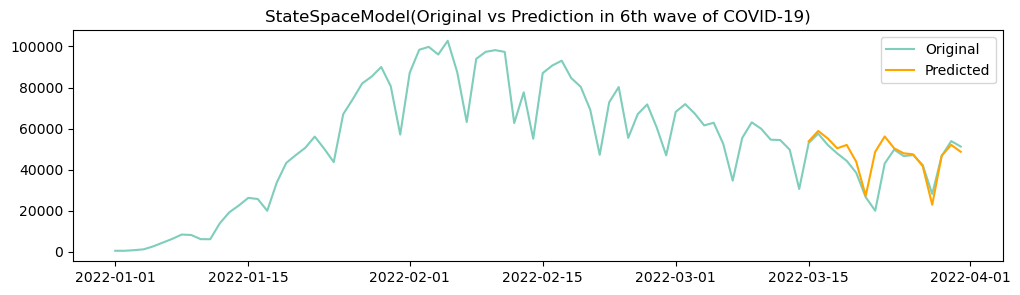

In [15]:
plt.figure(figsize=(12, 3))
plt.plot(df['original']['2022-01-01':'2022-03-31'], label='Original',color='#7FCDBB')
plt.plot(y_pred, label='Predicted',color='orange')
plt.legend()
plt.title('StateSpaceModel(Original vs Prediction in 6th wave of COVID-19)')
plt.savefig("./image/SS1.jpeg", dpi=300)
plt.show()

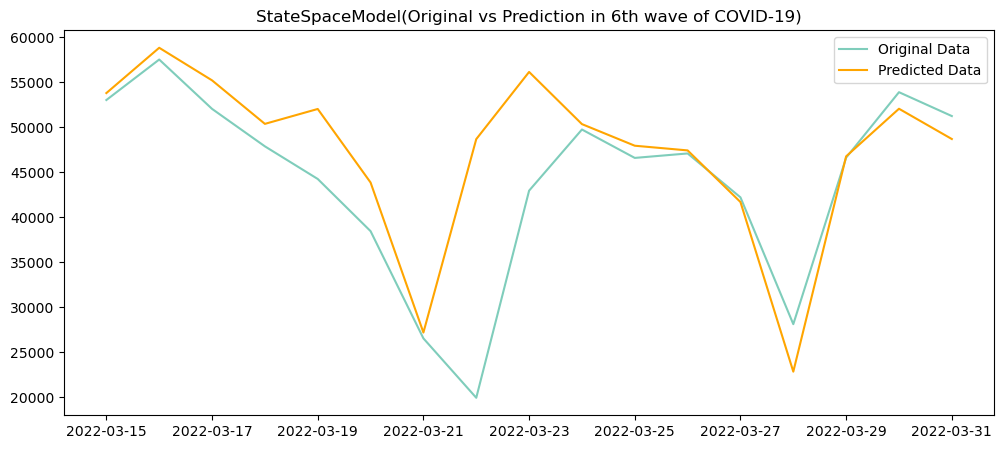

In [16]:
plt.figure(figsize=(12, 5))
plt.plot(y_test, color='#7FCDBB', label='Original Data')
plt.plot(y_pred, color='orange', label='Predicted Data')
plt.legend()
plt.title('StateSpaceModel(Original vs Prediction in 6th wave of COVID-19)')

plt.savefig("./image/SS2.jpeg", dpi=300)
plt.show()

#### 予測精度の評価